# MSc Thesis Jesper Arts

## Load Libraries

In [1]:
# Import necessary libraries
import refinitiv.data as rd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import datetime as dt
import pandas as pd
import numpy as np
import time
from refinitiv.data.content import filings as rfil

## Open Refinitiv Session

In [2]:
# Start session
rd.open_session()


<refinitiv.data.session.Definition object at 0x11bf7b050 {name='workspace'}>

In [157]:
# small check if it works
df = rd.get_data(
    universe=["AAPL.O"],
    fields=["TR.PriceClose", "TR.CompanyName", "TR.GICSSector"]
)

df


,Instrument,Price Close,Company Name,GICS Sector Name
0,AAPL.O,278.78,Apple Inc,Information Technology


## Create S&P 500 Master Table

In [3]:
rd.open_session()  # safe to call again

today = dt.date.today().isoformat()  # e.g. '2025-11-29'

spx_constituents = rd.get_data(
    universe=["0#.SPX"],
    fields=[
        "TR.IndexConstituentRIC",
        "TR.IndexConstituentName"
    ],
    parameters={
        "SDate": today  # or '2024-01-02' etc., any recent date is fine
    }
)

spx_df = pd.DataFrame(spx_constituents)
spx_df



,Instrument,Constituent RIC,Constituent Name
0,SMCI.OQ,SMCI.OQ,Super Micro Computer Inc
1,BAC.N,BAC.N,Bank of America Corp
2,MSFT.OQ,MSFT.OQ,Microsoft Corp
3,AMP.N,AMP.N,Ameriprise Financial Inc
4,HPQ.N,HPQ.N,HP Inc
...,...,...,...
498,TMUS.OQ,TMUS.OQ,T-Mobile US Inc
499,GEV.N,GEV.N,GE Vernova Inc
500,DG.N,DG.N,Dollar General Corp
501,WAT.N,WAT.N,Waters Corp


In [4]:
# 1) RIC list from the constituents table you already have
ric_list = spx_df["Constituent RIC"].dropna().unique().tolist()

def chunk_list(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

fields_meta = [
    "TR.RIC",
    "TR.CompanyName",
    "TR.GICSSector",
    "TR.GICSIndustryGroup",
    "TR.GICSIndustry",
    "TR.GICSSubIndustry",
    "TR.GICSSectorCode",
    "TR.ISIN",
    "TR.PrimaryQuote",
    "TR.OrganizationID"
]

all_chunks = []

for chunk in chunk_list(ric_list, 60):  # batches of 60 RICs
    chunk_df = rd.get_data(universe=chunk, fields=fields_meta)
    # chunk_df is already a DataFrame
    if chunk_df is not None and not chunk_df.empty:
        all_chunks.append(chunk_df)

sp500_meta_df = (
    pd.concat(all_chunks, ignore_index=True)
      .drop_duplicates(subset=["RIC"])
)

sp500_meta_df


,Instrument,RIC,Company Name,GICS Sector Name,GICS Industry Group Name,GICS Industry Name,GICS Sub-Industry Name,GICS Sector Code,ISIN,Primary Quote RIC,Organization PermID
0,SMCI.OQ,SMCI.OQ,Super Micro Computer Inc,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",45,US86800U3023,SMCI.OQ,4295907325
1,BAC.N,BAC.N,Bank of America Corp,Financials,Banks,Banks,Diversified Banks,40,US0605051046,BAC.N,8589934339
2,MSFT.OQ,MSFT.OQ,Microsoft Corp,Information Technology,Software & Services,Software,Systems Software,45,US5949181045,MSFT.OQ,4295907168
3,AMP.N,AMP.N,Ameriprise Financial Inc,Financials,Financial Services,Capital Markets,Asset Management & Custody Banks,40,US03076C1062,AMP.N,4295899980
4,HPQ.N,HPQ.N,HP Inc,Information Technology,Technology Hardware & Equipment,"Technology Hardware, Storage & Peripherals","Technology Hardware, Storage & Peripherals",45,US40434L1052,HPQ.N,4295904170
...,...,...,...,...,...,...,...,...,...,...,...
498,TMUS.OQ,TMUS.OQ,T-Mobile US Inc,Communication Services,Telecommunication Services,Wireless Telecommunication Services,Wireless Telecommunication Services,50,US8725901040,TMUS.OQ,4295900188
499,GEV.N,GEV.N,GE Vernova Inc,Industrials,Capital Goods,Electrical Equipment,Heavy Electrical Equipment,20,US36828A1016,GEV.N,5086720112
500,DG.N,DG.N,Dollar General Corp,Consumer Staples,Consumer Staples Distribution & Retail,Consumer Staples Distribution & Retail,Consumer Staples Merchandise Retail,30,US2566771059,DG.N,4295903123
501,WAT.N,WAT.N,Waters Corp,Health Care,"Pharmaceuticals, Biotechnology & Life Sciences",Life Sciences Tools & Services,Life Sciences Tools & Services,35,US9418481035,WAT.N,4295905309


In [160]:
sp500_meta_df.to_csv(
    "sp500_master_data.csv",
    index=False
)

## Get company performance indicators

### Set up Quarters

In [32]:
import refinitiv.data as rd
import pandas as pd
from datetime import datetime

rd.open_session()  # safe to call again

# --- Define quarter-end dates from 2018 to 2025 ---
quarters = []
for year in range(2018, 2026):
    for month in [3, 6, 9, 12]:
        if month == 3:
            day = 31
        elif month == 6:
            day = 30
        elif month == 9:
            day = 30
        else:
            day = 31  # December

        date_str = f"{year}-{month:02d}-{day:02d}"
        quarters.append(date_str)

print("Quarter endpoints:", len(quarters))


Quarter endpoints: 32


In [33]:
# --- Load RICs ---
master = pd.read_csv("sp500_master_data.csv")
rics = master["RIC"].dropna().unique().tolist()

CHUNK_SIZE = 50
all_rows = []


In [ ]:

for qdate in quarters:
    print(f"=== Quarter snapshot: {qdate} ===")

    for start in range(0, len(rics), CHUNK_SIZE):
        chunk = rics[start:start + CHUNK_SIZE]

        try:
            # Data Library returns a single DataFrame-like object
            df = rd.get_data(
                universe=chunk,
                fields=["TR.CLOSEPRICE", "TR.CompanyMarketCapitalization", "TR.ROAMean"],
                parameters={
                    "SDate": qdate,
                    "EDate": qdate,
                }
            )

            # some versions wrap the DataFrame in .data
            if hasattr(df, "data"):
                df = df.data

            if isinstance(df, pd.DataFrame) and not df.empty:
                df["Date"] = qdate
                all_rows.append(df)
            else:
                print(f"  No data for chunk starting at {start} on {qdate}")

        except Exception as e:
            print(f"Error: {e}")

# --- Combine ---
price_df = pd.concat(all_rows, ignore_index=True)

price_df


=== Quarter snapshot: 2018-03-31 ===
=== Quarter snapshot: 2018-06-30 ===
=== Quarter snapshot: 2018-09-30 ===
=== Quarter snapshot: 2018-12-31 ===
=== Quarter snapshot: 2019-03-31 ===
=== Quarter snapshot: 2019-06-30 ===
=== Quarter snapshot: 2019-09-30 ===
=== Quarter snapshot: 2019-12-31 ===
=== Quarter snapshot: 2020-03-31 ===
=== Quarter snapshot: 2020-06-30 ===
=== Quarter snapshot: 2020-09-30 ===
=== Quarter snapshot: 2020-12-31 ===
=== Quarter snapshot: 2021-03-31 ===
=== Quarter snapshot: 2021-06-30 ===
=== Quarter snapshot: 2021-09-30 ===
=== Quarter snapshot: 2021-12-31 ===
=== Quarter snapshot: 2022-03-31 ===
=== Quarter snapshot: 2022-06-30 ===
=== Quarter snapshot: 2022-09-30 ===
=== Quarter snapshot: 2022-12-31 ===
=== Quarter snapshot: 2023-03-31 ===
=== Quarter snapshot: 2023-06-30 ===
=== Quarter snapshot: 2023-09-30 ===
=== Quarter snapshot: 2023-12-31 ===
=== Quarter snapshot: 2024-03-31 ===
=== Quarter snapshot: 2024-06-30 ===
=== Quarter snapshot: 2024-09-30 ===
=

,Instrument,Close Price,Company Market Capitalization,Return On Assets - Mean,Date
0,DASH.OQ,<NA>,<NA>,<NA>,2018-03-31
1,IFF.N,136.91,10803886141.93,10.525,2018-03-31
2,PAYC.N,107.39,6194580484.31,17.897,2018-03-31
3,TSCO.OQ,12.604,7884867668.2,17.34814,2018-03-31
4,MOH.N,81.18,4867422993.18,2.9,2018-03-31
...,...,...,...,...,...
16091,PPL.N,,25750320751.369999,6.2,2025-12-31
16092,JBHT.OQ,,17893431580.32,7.15,2025-12-31
16093,VMC.N,,38660181493.949997,6.75,2025-12-31
16094,HSY.N,,36629076586.860001,9.075,2025-12-31


In [62]:
# --- Clean columns ---
price_df = price_df.rename(columns={
    "Instrument": "RIC",
    "Close Price": "ClosePrice",
    "Company Market Capitalization": "MarketCap",
    "Return On Assets - Mean": "ROA"
})

# Extract year/quarter
price_df["Date"] = pd.to_datetime(price_df["Date"])
price_df["Year"] = price_df["Date"].dt.year
price_df["Quarter"] = price_df["Date"].dt.quarter


In [63]:
# --- Save ---
price_df.to_csv("sp500_stockprice_quarterly.csv", index=False)

## Get control variables

In [34]:
controls_all = []

for qdate in quarters:
    print(f"=== Quarter fundamentals: {qdate} ===")

    for start in range(0, len(rics), CHUNK_SIZE):
        chunk = rics[start:start + CHUNK_SIZE]

        try:
            # Data Library returns a single object, not (df, err)
            df = rd.get_data(
                universe=chunk,
                fields=[
                    "TR.F.TotAssets",                 # total assets
                    "TR.F.DebtTot",                   # total debt
                    "TR.RnDExpActual",                      # R&D expense
                    "TR.RevenueMean",                 # revenue
                    "TR.F.CAPEXTot",                  # capex
                    "TR.BVPSMean",                     # book value per share
                    "TR.NetProfitMean",                 # net income
                    "TR.OrgFoundedYear"                # founding year
                ],
                parameters={
                    "SDate": qdate,
                    "EDate": qdate,
                    "FRQ": "Q"
                }
            )

            # some versions wrap the DataFrame in .data
            if hasattr(df, "data"):
                df = df.data

            if isinstance(df, pd.DataFrame) and not df.empty:
                df["Date"] = qdate
                controls_all.append(df)
            else:
                print(f"  No controls data for chunk starting at {start} on {qdate}")

        except Exception as e:
            print(f"Error: {e}")

# --- Combine all quarters ---
controls_df = pd.concat(controls_all, ignore_index=True)

controls_df


=== Quarter fundamentals: 2018-03-31 ===
=== Quarter fundamentals: 2018-06-30 ===
=== Quarter fundamentals: 2018-09-30 ===
=== Quarter fundamentals: 2018-12-31 ===
=== Quarter fundamentals: 2019-03-31 ===
=== Quarter fundamentals: 2019-06-30 ===
=== Quarter fundamentals: 2019-09-30 ===
=== Quarter fundamentals: 2019-12-31 ===
=== Quarter fundamentals: 2020-03-31 ===
=== Quarter fundamentals: 2020-06-30 ===
=== Quarter fundamentals: 2020-09-30 ===
=== Quarter fundamentals: 2020-12-31 ===
=== Quarter fundamentals: 2021-03-31 ===
=== Quarter fundamentals: 2021-06-30 ===
=== Quarter fundamentals: 2021-09-30 ===
=== Quarter fundamentals: 2021-12-31 ===
=== Quarter fundamentals: 2022-03-31 ===
=== Quarter fundamentals: 2022-06-30 ===
=== Quarter fundamentals: 2022-09-30 ===
=== Quarter fundamentals: 2022-12-31 ===
=== Quarter fundamentals: 2023-03-31 ===
=== Quarter fundamentals: 2023-06-30 ===
=== Quarter fundamentals: 2023-09-30 ===
=== Quarter fundamentals: 2023-12-31 ===
=== Quarter fund

,Instrument,Total Assets,Debt - Total,R&D Expense - Actual,Revenue - Mean,Capital Expenditures - Total,Book Value Per Share - Mean,Net Income - Mean,Organization Founded Year,Date
0,SMCI.OQ,1515130000.0,161447000.0,129112000,3053225000,29365000.0,<NA>,88290250,2006,2018-03-31
1,BAC.N,2281234000000.0,436933000000.0,<NA>,92425388920,<NA>,25.1955,25587259130,1998,2018-03-31
2,MSFT.OQ,250312000000.0,88732000000.0,13037000000,107262993410,8129000000.0,11.32714,28212379720,1993,2018-03-31
3,AMP.N,147480000000.0,5297000000.0,<NA>,12661307860,162000000.0,42.75586,2157285300,1983,2018-03-31
4,HPQ.N,32913000000.0,7819000000.0,1190000000,56585419500,402000000.0,-1.125,3259308610,1998,2018-03-31
...,...,...,...,...,...,...,...,...,...,...
16091,TMUS.OQ,208035000000.0,84255000000.0,0,88201234850,12311000000.0,52.78557,11390323600,2004,2025-12-31
16092,GEV.N,51485000000.0,436000000.0,982000000,37301667250,883000000.0,39.24,2051675330,2023,2025-12-31
16093,DG.N,31132733000.0,6238488000.0,0,42536494110,1309888000.0,38.636,1395306580,1998,2025-12-31
16094,WAT.N,4553795000.0,1626488000.0,177065000,3162491770,142481000.0,43.50167,782175500,1991,2025-12-31


In [35]:
# Count missing values per column
missing_count = controls_df.isna().sum()

# Percentage missing
missing_pct = (controls_df.isna().mean() * 100).round(2)

# Combine into one table
missing_table = pd.DataFrame({
    'Missing_Count': missing_count,
    'Missing_Percentage': missing_pct
}).sort_values(by='Missing_Percentage', ascending=False)

# Display the table
missing_table


,Missing_Count,Missing_Percentage
R&D Expense - Actual,9190,57.09
Book Value Per Share - Mean,781,4.85
Capital Expenditures - Total,652,4.05
Debt - Total,463,2.88
Net Income - Mean,446,2.77
Revenue - Mean,442,2.75
Total Assets,210,1.30
Instrument,0,0.00
Organization Founded Year,0,0.00
Date,0,0.00


In [36]:
# --- Rename to clean variable names (using YOUR chosen field codes) ---
controls_df = controls_df.rename(columns={
    "Instrument": "RIC",
    "Total Assets": "TotalAssets",
    "Debt - Total": "TotalDebt",
    "R&D Expense - Actual": "RND",
    "Revenue - Mean": "Revenue",
    "Capital Expenditures - Total": "Capex",
    "Book Value Per Share - Mean": "BookValuePerShare",
    "Net Income - Mean": "NetIncome",
    "Organization Founded Year": "FoundedYear"
})

# --- Add Year / Quarter ---
controls_df["Date"] = pd.to_datetime(controls_df["Date"])
controls_df["Year"] = controls_df["Date"].dt.year
controls_df["Quarter"] = controls_df["Date"].dt.quarter

# --- Save ---
controls_df.to_csv("sp500_controls_quarterly.csv", index=False)

In [37]:
controls_df

,RIC,TotalAssets,TotalDebt,RND,Revenue,Capex,BookValuePerShare,NetIncome,FoundedYear,Date,Year,Quarter
0,SMCI.OQ,1515130000.0,161447000.0,129112000,3053225000,29365000.0,<NA>,88290250,2006,2018-03-31,2018,1
1,BAC.N,2281234000000.0,436933000000.0,<NA>,92425388920,<NA>,25.1955,25587259130,1998,2018-03-31,2018,1
2,MSFT.OQ,250312000000.0,88732000000.0,13037000000,107262993410,8129000000.0,11.32714,28212379720,1993,2018-03-31,2018,1
3,AMP.N,147480000000.0,5297000000.0,<NA>,12661307860,162000000.0,42.75586,2157285300,1983,2018-03-31,2018,1
4,HPQ.N,32913000000.0,7819000000.0,1190000000,56585419500,402000000.0,-1.125,3259308610,1998,2018-03-31,2018,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16091,TMUS.OQ,208035000000.0,84255000000.0,0,88201234850,12311000000.0,52.78557,11390323600,2004,2025-12-31,2025,4
16092,GEV.N,51485000000.0,436000000.0,982000000,37301667250,883000000.0,39.24,2051675330,2023,2025-12-31,2025,4
16093,DG.N,31132733000.0,6238488000.0,0,42536494110,1309888000.0,38.636,1395306580,1998,2025-12-31,2025,4
16094,WAT.N,4553795000.0,1626488000.0,177065000,3162491770,142481000.0,43.50167,782175500,1991,2025-12-31,2025,4


## Prepare dicitonairies and variable construction

### Load all transcripts into dataframe

In [517]:
import os
import glob
import re
import pandas as pd
from datetime import datetime

# ========= CONFIG =========
TRANSCRIPTS_ROOT = "data/conference_calls"

MONTH_MAP = {
    "Jan": 1, "Feb": 2, "Mar": 3,
    "Apr": 4, "May": 5, "Jun": 6,
    "Jul": 7, "Aug": 8, "Sep": 9,
    "Oct": 10, "Nov": 11, "Dec": 12,
}

def extract_fiscal_yq_from_path(path: str):
    rel = os.path.relpath(path, TRANSCRIPTS_ROOT)
    parts = rel.split(os.sep)[:-1]  # directories only, exclude filename

    fiscal_year = None
    fiscal_quarter = None

    for part in parts:
        m = re.search(r'(?P<year>20\d{2})[-_ ]?Q(?P<q>[1-4])', part, flags=re.IGNORECASE)
        if m:
            fiscal_year = int(m.group('year'))
            fiscal_quarter = int(m.group('q'))
            break

        m2 = re.search(r'FY[ _-]?(?P<year>20\d{2})[ _-]?Q(?P<q>[1-4])', part, flags=re.IGNORECASE)
        if m2:
            fiscal_year = int(m2.group('year'))
            fiscal_quarter = int(m2.group('q'))
            break

    if fiscal_year is None or fiscal_quarter is None:
        for i, part in enumerate(parts):
            if re.fullmatch(r'Q[1-4]', part, flags=re.IGNORECASE) and i > 0:
                prev = parts[i - 1]
                if re.fullmatch(r'20\d{2}', prev):
                    fiscal_year = int(prev)
                    fiscal_quarter = int(part[1])  # "Q1" -> 1
                    break

    return fiscal_year, fiscal_quarter


def parse_transcript_filename(path: str):
    base = os.path.basename(path)
    name_no_ext = os.path.splitext(base)[0]

    parts = name_no_ext.split("-")
    year = int(parts[0])
    mon_str = parts[1]
    day = int(parts[2])
    ric = parts[3]

    month = MONTH_MAP[mon_str]
    date = datetime(year, month, day)
    quarter = (month - 1) // 3 + 1

    fy, fq = extract_fiscal_yq_from_path(path)
    if fy is None:
        fy = year
    if fq is None:
        fq = quarter

    return {
        "file_name": base,
        "full_path": path,
        "RIC": ric,
        "Year": year,
        "Month": month,
        "Day": day,
        "Quarter": quarter,
        "Date": date,
        "FiscalYear": fy,
        "FiscalQuarter": fq,
    }

# ========= FIND ALL FILES RECURSIVELY =========
pattern = os.path.join(TRANSCRIPTS_ROOT, "**", "*.txt")
file_paths = glob.glob(pattern, recursive=True)

print(f"Found {len(file_paths)} transcript files under {TRANSCRIPTS_ROOT}")

rows = [parse_transcript_filename(p) for p in file_paths]
corpus = pd.DataFrame(rows)

def load_text(path: str) -> str:
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()
    except Exception as e:
        print(f"Error reading {path}: {e}")
        return ""

corpus["raw_text"] = corpus["full_path"].apply(load_text)


Found 14937 transcript files under data/conference_calls


### Text Cleaining

In [518]:
import re

# ---------------------------------------------------------
# 1. Strip transcript structure (participants, boilerplate,
#    speaker labels, operator instructions, etc.)
# ---------------------------------------------------------
def strip_transcript_structure(text: str) -> str:
    """
    Remove as much non-content structure as possible from a
    Refinitiv-style earnings call transcript, while keeping
    the actual spoken content (management + analysts).
    """
    if not isinstance(text, str):
        return ""

    lines = text.splitlines()
    cleaned_lines = []

    # State for skipping participant lists
    in_participants_block = False

    # Keywords for boilerplate / disclaimers
    disclaimer_keywords = [
        "forward-looking statement",
        "forward looking statement",
        "safe harbor",
        "safe-harbor",
        "disclaimer",
        "refinitiv streetevents",
        "edited   version",
        "this transcript has been edited",
        "thomson reuters",
        "thomson-reuters",
        "factset",
        "copyright",
    ]

    # Regex for speaker labels (e.g. "Operator    [1]", "John Doe - CEO    [2]")
    speaker_pattern = re.compile(
        r"""^(
            operator|
            coordinator|
            unidentified\s+analyst|
            [A-Z][A-Za-z .,&'\-]{1,40}   # approx. person name
        )(
            \s*[-–]\s*[A-Za-z .,&'\-]+   # optional title after dash
        )?
        (\s*\[\d+\])?                    # optional [1], [2], ...
        \s*$""",
        re.IGNORECASE | re.VERBOSE
    )

    for line in lines:
        line = line.strip()
        if not line:
            continue

        lower = line.lower()

        # ----- 1) Skip obvious separator lines -----
        if re.fullmatch(r"=+", line):
            continue

        # ----- 2) Participant blocks -----
        if any(kw in lower for kw in [
            "corporate participants",
            "conference call participants",
            "conference call participiants"  # typo in some files
        ]):
            in_participants_block = True
            continue

        if in_participants_block:
            # End participant block when we hit the start of the actual call
            if ("presentation" in lower) or lower.startswith("presentation") \
               or lower.startswith("operator") or lower.startswith("welcome to"):
                in_participants_block = False
                # we do NOT keep this transition line itself
                continue
            # otherwise skip participant list lines
            continue

        # ----- 3) Skip boilerplate / legal disclaimers -----
        if any(kw in lower for kw in disclaimer_keywords):
            continue

        # Skip lines that are just section headings like "Presentation"
        if lower in {"presentation", "questions and answers", "question-and-answer session"}:
            continue

        # Skip operator instructions lines
        if "operator instructions" in lower:
            continue

        # ----- 4) Remove bracketed stage directions -----
        # e.g. [Operator Instructions], [3], [Q&A]
        line = re.sub(r"\[[^\]]+\]", " ", line).strip()
        if not line:
            continue
        lower = line.lower()

        # ----- 5) Remove speaker label-only lines -----
        if speaker_pattern.match(line):
            # whole line is just "Speaker, Title [2]" or "Operator [1]"
            continue

        # ----- 6) Drop very short noise lines (e.g. "Thank you.") -----
        # Keep at least 3-word lines to focus on substantive content
        if len(line.split()) < 3:
            continue

        # Collapse whitespace again
        line = re.sub(r"\s+", " ", line).strip()
        if line:
            cleaned_lines.append(line)

    return " ".join(cleaned_lines)


# ---------------------------------------------------------
# 2. Basic token-level cleaning (same spirit as before)
# ---------------------------------------------------------
def basic_clean(text: str) -> str:
    """
    Lowercase + remove punctuation; keep letters/numbers and spaces.
    """
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


# ---------------------------------------------------------
# 3. Combine into final clean_text + tokens
# ---------------------------------------------------------
def clean_transcript_text(raw_text: str) -> str:
    body = strip_transcript_structure(raw_text)
    return basic_clean(body)

# Apply to your corpus
corpus["clean_text"] = corpus["raw_text"].apply(clean_transcript_text)

from collections import Counter

vocab_counter = Counter()
for txt in corpus["clean_text"]:
    if isinstance(txt, str):
        for tok in txt.split():
            tok = tok.strip()
            if tok.isalpha():
                vocab_counter[tok] += 1

vocab_tokens = set(vocab_counter.keys())

corpus["tokens"] = corpus["clean_text"].apply(
    lambda x: x.split() if isinstance(x, str) else []
)



### Define preliminary dictionaries
These are constructed based on prior literature and common sense. They will be further refined using word embeddings later on.

In [520]:
sensing_terms = [
    "scan", "scanning", "search", "searching", "explore", "exploring",
    "monitor", "monitoring", "sense", "sensing",
    "identify", "identifying", "detect", "detecting",
    "anticipate", "anticipating", "observe", "observing",
    "evaluate", "evaluating", "assess", "assessing",
    "track", "tracking",
    "market intelligence", "competitive intelligence",
    "customer needs", "customer insights",
    "environmental scanning",
    "trend identification", "trend spotting",
    "pattern recognition",
    "technology scouting",
    "opportunity identification",
    "emerging technologies",
    "gather external knowledge",
    "best practices"
]

seizing_terms = [
    "invest", "investing", "investment",
    "commit", "committing", "commitment",
    "allocate", "allocating", "resource allocation",
    "mobilize", "mobilizing",
    "capture value",
    "commercialize", "commercializing", "commercialization",
    "evaluate", "evaluating", "assess alternatives",
    "decide", "decision making",
    "prioritize opportunities",
    "seize opportunities",
    "business model design", "design business model",
    "launch initiative", "launch project",
    "implement", "implementing",
    "adopt",
    "exploit opportunities",
    "initiate project", "initiate initiative"
]

transforming_terms = [
    "reconfigure", "reconfiguring", "reconfiguration",
    "restructure", "restructuring",
    "redeploy", "redeployment",
    "recombine", "recombining",
    "realign", "realigning",
    "renew", "renewal",
    "adapt", "adapting", "adaptation",
    "transform", "transforming", "transformation",
    "modify", "modifying",
    "upgrade", "upgrading",
    "orchestrate", "orchestrating",
    "integrate", "integration",
    "reengineer", "reengineering",
    "redesign", "process redesign", "workflow redesign",
    "continuous improvement",
    "update processes",
    "reallocate resources",
    "discontinue practices",
    "organizational redesign",
    "organizational change",
    "resource reconfiguration"
]

genai_core_terms = [
    "generative ai", "gen ai", "genai",
    "large language model", "large-language model", "llm",
    "foundation model", "foundational model",
    "chatgpt", "gpt", "gpt-3", "gpt3", "gpt-4", "gpt4", "gpt-4o",
    "openai", "anthropic", "claude",
    "google gemini", "gemini model",
    "meta llama", "llama 2", "llama 3",
    "azure openai",
    "microsoft copilot", "github copilot", "ai copilot",
    "ai assistant", "ai assistants",
    "ai agent", "ai agents"
]

genai_strategy_terms = [
    "genai strategy",
    "genai roadmap",
    "genai adoption",
    "genai implementation",
    "genai initiative", "genai initiatives",
    "genai capability", "genai capabilities",
    "genai infrastructure",
    "genai platform", "genai platforms",
    "genai investments", "genai investment",
    "genai deployment",
    "genai solution", "genai solutions",
    "llm deployment", "llm integration",
    "foundation model deployment", "foundation model integration",
    "llm-enabled", "llm powered", "llm-powered",
    "genai powered", "genai-enabled"
]

genai_usecase_terms = [
    "text generation", "content generation", "code generation",
    "document processing", "document understanding",
    "semantic search", "intelligent search",
    "knowledge assistant", "search assistant",
    "chatbot", "virtual assistant", "ai chatbot",
    "customer service bot", "call center automation",
    "workflow automation", "process automation",
    "automated decision", "automated decisions",
    "recommendation system", "recommender system",
    "synthetic data",
    "fine-tuning", "fine tuning",
    "model inference",
    "natural language interface", "natural language query", "natural language queries"
]



### Synonym expansion of deductive dictionary
This model will be used to further refine the dictionaries with synonyms. 

In [49]:
from collections import Counter

vocab_counter = Counter()
for txt in corpus["clean_text"]:
    if isinstance(txt, str):
        for tok in txt.split():
            tok = tok.strip()
            if tok.isalpha():
                vocab_counter[tok] += 1

# If you still want a vocab set:
vocab_tokens = set(vocab_counter.keys())



In [50]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
import math

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

stop = set(stopwords.words("english"))

def get_top_wordnet_synonyms(token, vocab_counter, max_syn=2, min_corpus_freq=5):
    """
    Get up to `max_syn` synonyms for a single token, ranked by:
    - how often they appear in your corpus
    - how frequent they are in WordNet (lemma.count()).
    """
    candidates = {}

    for synset in wn.synsets(token):
        # only verbs and nouns, to avoid weird adjectives/adverbs
        if synset.pos() not in ("v", "n"):
            continue

        for lemma in synset.lemmas():
            cand = lemma.name().replace("_", " ").lower()

            # basic filters
            if cand == token:
                continue
            if len(cand) < 4:
                continue
            if cand in stop:
                continue
            if not cand.isalpha():
                continue

            # only keep synonyms that actually occur in your transcripts
            corpus_freq = vocab_counter.get(cand, 0)
            if corpus_freq < min_corpus_freq:
                continue

            wn_freq = lemma.count()  # WordNet usage frequency
            # simple score: weight corpus frequency more heavily
            score = corpus_freq * 10 + wn_freq

            # keep the best score per candidate
            if cand not in candidates or score > candidates[cand]["score"]:
                candidates[cand] = {
                    "score": score,
                    "corpus_freq": corpus_freq,
                    "wn_freq": wn_freq
                }

    # turn into list and sort
    cand_list = [
        (cand, info["score"], info["corpus_freq"], info["wn_freq"])
        for cand, info in candidates.items()
    ]
    cand_list.sort(key=lambda x: x[1], reverse=True)

    # return at most `max_syn` best synonyms
    return cand_list[:max_syn]


def suggest_synonyms_for_dict(seed_terms, vocab_counter, max_syn_per_token=2, min_corpus_freq=5):
    """
    For a list of seed terms (possibly multi-word),
    return a small table of top synonyms per base token.
    Does NOT modify your dictionary yet – just suggests candidates.
    """
    seen_tokens = set()
    rows = []

    # Extract unique base tokens from phrases
    for phrase in seed_terms:
        for w in phrase.split():
            w = w.lower()
            if w in seen_tokens:
                continue
            seen_tokens.add(w)

            syns = get_top_wordnet_synonyms(
                token=w,
                vocab_counter=vocab_counter,
                max_syn=max_syn_per_token,
                min_corpus_freq=min_corpus_freq
            )

            for cand, score, cfreq, wnfreq in syns:
                rows.append({
                    "base_token": w,
                    "synonym": cand,
                    "score": score,
                    "corpus_freq": cfreq,
                    "wordnet_freq": wnfreq
                })

    return pd.DataFrame(rows).sort_values(["base_token", "score"], ascending=[True, False])


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jesperarts/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/jesperarts/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jesperarts/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
sensing_syn_suggestions = suggest_synonyms_for_dict(
    seed_terms=sensing_terms,
    vocab_counter=vocab_counter,
    max_syn_per_token=2,   # 1–2 per word
    min_corpus_freq=10     # only synonyms seen at least 10 times in transcripts
)

sensing_syn_suggestions.head(30)



,base_token,synonym,score,corpus_freq,wordnet_freq
27,anticipate,call,2847460,284746,0
28,anticipate,expect,2104104,210390,204
29,anticipating,call,2847460,284746,0
30,anticipating,expect,2104104,210390,204
39,assess,value,945680,94568,0
40,assess,evaluate,59918,5990,18
41,assessing,value,945680,94568,0
42,assessing,evaluate,59918,5990,18
76,best,trump,4760,476,0
77,best,scoop,580,58,0


In [52]:
seizing_syn_suggestions = suggest_synonyms_for_dict(seizing_terms, vocab_counter, 2, 10)
transforming_syn_suggestions = suggest_synonyms_for_dict(transforming_terms, vocab_counter, 2, 10)


In [53]:
sensing_syn_suggestions.to_csv("sensing_synonym_suggestions.csv", index=False)
seizing_syn_suggestions.to_csv("seizing_synonym_suggestions.csv", index=False)
transforming_syn_suggestions.to_csv("transforming_synonym_suggestions.csv", index=False)


In [521]:
sensing_extra_synonyms = [
    "discover",
    "research",
    "scout",
    "read",
    "recognize"
]

seizing_extra_synonyms = [
    "capture",
    "innovation",
    "apply",
    "start"
]

transforming_extra_synonyms = [
    "adjust",
    "replacement",
    "reconstitute"
]

### Deductive dictionary

In [522]:
# =========================
# FINAL SENSING DICTIONARY
# =========================

sensing_terms = sorted(set([
    "scan", "scanning", "search", "searching", "explore", "exploring",
    "monitor", "monitoring", "sense", "sensing",
    "identify", "identifying", "detect", "detecting",
    "anticipate", "anticipating", "observe", "observing",
    "evaluate", "evaluating", "assess", "assessing",
    "track", "tracking",
    "market intelligence", "competitive intelligence",
    "customer needs", "customer insights",
    "environmental scanning",
    "trend identification", "trend spotting",
    "pattern recognition",
    "technology scouting",
    "opportunity identification",
    "emerging technologies",
    "gather external knowledge",
    "best practices",

    # Added synonyms
    "discover",
    "research",
    "scout",
    "read",
    "recognize"
]))


# =========================
# FINAL SEIZING DICTIONARY
# =========================

seizing_terms = sorted(set([
    "invest", "investing", "investment",
    "commit", "committing", "commitment",
    "allocate", "allocating", "resource allocation",
    "mobilize", "mobilizing",
    "capture value",
    "commercialize", "commercializing", "commercialization",
    "evaluate", "evaluating", "assess alternatives",
    "decide", "decision making",
    "prioritize opportunities",
    "seize opportunities",
    "business model design", "design business model",
    "launch initiative", "launch project",
    "implement", "implementing",
    "adopt",
    "exploit opportunities",
    "initiate project", "initiate initiative",

    # Added synonyms
    "capture",
    "innovation",
    "apply",
    "start"
]))


# ==============================
# FINAL TRANSFORMING DICTIONARY
# ==============================

transforming_terms = sorted(set([
    "reconfigure", "reconfiguring", "reconfiguration",
    "restructure", "restructuring",
    "redeploy", "redeployment",
    "recombine", "recombining",
    "realign", "realigning",
    "renew", "renewal",
    "adapt", "adapting", "adaptation",
    "transform", "transforming", "transformation",
    "modify", "modifying",
    "upgrade", "upgrading",
    "orchestrate", "orchestrating",
    "integrate", "integration",
    "reengineer", "reengineering",
    "redesign", "process redesign", "workflow redesign",
    "continuous improvement",
    "update processes",
    "reallocate resources",
    "discontinue practices",
    "organizational redesign",
    "organizational change",
    "resource reconfiguration",

    # Added synonyms
    "adjust",
    "replacement",
    "reconstitute"
]))


# ==============================
# GENAI DICTIONARIES (UNCHANGED)
# ==============================

genai_core_terms = [
    "generative ai", "gen ai", "genai",
    "large language model", "large-language model", "llm",
    "foundation model", "foundational model",
    "chatgpt", "gpt", "gpt-3", "gpt3", "gpt-4", "gpt4", "gpt-4o",
    "openai", "anthropic", "claude",
    "google gemini", "gemini model",
    "meta llama", "llama 2", "llama 3",
    "azure openai",
    "microsoft copilot", "github copilot", "ai copilot",
    "ai assistant", "ai assistants",
    "ai agent", "ai agents"
]

genai_strategy_terms = [
    "genai strategy",
    "genai roadmap",
    "genai adoption",
    "genai implementation",
    "genai initiative", "genai initiatives",
    "genai capability", "genai capabilities",
    "genai infrastructure",
    "genai platform", "genai platforms",
    "genai investments", "genai investment",
    "genai deployment",
    "genai solution", "genai solutions",
    "llm deployment", "llm integration",
    "foundation model deployment", "foundation model integration",
    "llm-enabled", "llm powered", "llm-powered",
    "genai powered", "genai-enabled"
]

genai_usecase_terms = [
    "text generation", "content generation", "code generation",
    "document processing", "document understanding",
    "semantic search", "intelligent search",
    "knowledge assistant", "search assistant",
    "chatbot", "virtual assistant", "ai chatbot",
    "customer service bot", "call center automation",
    "workflow automation", "process automation",
    "automated decision", "automated decisions",
    "recommendation system", "recommender system",
    "synthetic data",
    "fine-tuning", "fine tuning",
    "model inference",
    "natural language interface", "natural language query", "natural language queries"
]


### Inductive Dictionary Expansion

In [80]:
from collections import Counter
import pandas as pd
from tqdm import tqdm   # progress bar

def find_inductive_candidates_token_based(corpus_df, seed_terms, window=5, min_freq=20, desc="Scanning transcripts"):
    """
    Token-based inductive candidate finder with basic speed optimizations:

    - Uses precomputed 'tokens' column in corpus_df
    - Skips docs that have no overlap with single-word seeds
    - Handles single-word and multi-word seeds
    """
    # Normalize seeds
    seed_terms = [s.lower() for s in seed_terms]

    # Split into single- and multi-word patterns
    single_word_seeds = [s for s in seed_terms if len(s.split()) == 1]
    multi_word_seeds = [s for s in seed_terms if len(s.split()) > 1]

    single_word_seeds_set = set(single_word_seeds)

    co_rows = []

    # Ensure tokens column exists
    if "tokens" not in corpus_df.columns:
        raise ValueError("corpus_df must contain a 'tokens' column with pre-tokenized text.")

    for _, row in tqdm(corpus_df.iterrows(), total=len(corpus_df), desc=desc):
        tokens = row["tokens"]
        if not tokens:
            continue

        n = len(tokens)
        token_set = set(tokens)

        # Quick skip: if no single-word seed token is present and no multi-word seeds
        if not (token_set & single_word_seeds_set) and not multi_word_seeds:
            continue

        # 1) Single-word seeds: exact token match
        for i, tok in enumerate(tokens):
            if tok in single_word_seeds_set:
                left = max(0, i - window)
                right = min(n, i + 1 + window)
                context = tokens[left:right]

                for w in context:
                    if w == tok:
                        continue
                    co_rows.append((tok, w))

        # 2) Multi-word seeds: sliding window over token sequences
        for phrase in multi_word_seeds:
            parts = phrase.split()
            k = len(parts)
            if k > n:
                continue

            for i in range(n - k + 1):
                if tokens[i:i+k] == parts:
                    left = max(0, i - window)
                    right = min(n, i + k + window)
                    context = tokens[left:right]

                    for w in context:
                        if w in parts:
                            continue
                        co_rows.append((phrase, w))

    # Aggregate co-occurrences
    if not co_rows:
        return pd.DataFrame(columns=["seed_term", "candidate", "freq"])

    df = pd.DataFrame(co_rows, columns=["seed_term", "candidate"])
    df = df.groupby(["seed_term", "candidate"]).size().reset_index(name="freq")

    # Apply frequency filter
    df = df[df["freq"] >= min_freq]

    # Sort
    df = df.sort_values(["seed_term", "freq"], ascending=[True, False]).reset_index(drop=True)
    return df


In [81]:
sensing_inductive = find_inductive_candidates_token_based(
    corpus_df=corpus,
    seed_terms=sensing_terms,
    window=5,
    min_freq=20
)
sensing_inductive.to_csv("inductive_candidates_sensing.csv", index=False)


Scanning transcripts: 100%|██████████| 14942/14942 [06:36<00:00, 37.71it/s]


In [85]:
seizing_inductive = find_inductive_candidates_token_based(
    corpus_df=corpus,
    seed_terms=seizing_terms,
    window=5,
    min_freq=20
)
seizing_inductive.to_csv("inductive_candidates_seizing.csv", index=False)


Scanning transcripts: 100%|██████████| 14942/14942 [06:59<00:00, 35.65it/s] 


In [86]:
transforming_inductive = find_inductive_candidates_token_based(
    corpus_df=corpus,
    seed_terms=transforming_terms,
    window=5,
    min_freq=20
)
transforming_inductive.to_csv("inductive_candidates_transforming.csv", index=False)


Scanning transcripts: 100%|██████████| 14942/14942 [04:27<00:00, 55.89it/s]


In [87]:
genai_seeds = genai_core_terms + genai_strategy_terms + genai_usecase_terms

genai_inductive = find_inductive_candidates_token_based(
    corpus_df=corpus,
    seed_terms=genai_seeds,
    window=5,
    min_freq=20
)
genai_inductive.to_csv("inductive_candidates_genai.csv", index=False)


Scanning transcripts: 100%|██████████| 14942/14942 [36:57<00:00,  6.74it/s]    


In [101]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk

def clean_inductive_csv(
    df,
    seed_terms,
    min_freq=20,
    remove_short_words=True,
    remove_common_business_terms=True
):
    """
    Cleans the inductive candidate DataFrame by:
    - removing stopwords
    - removing seed terms
    - removing punctuation, numbers, short tokens
    - removing generic business words
    """

    stop = set(stopwords.words("english"))

    # 1. Lowercase candidate column
    df["candidate"] = df["candidate"].astype(str).str.lower()

    # 2. Remove punctuation/numeric-only tokens
    df = df[df["candidate"].str.contains(r"[a-zA-Z]", regex=True)]

    # 3. Remove stopwords
    df = df[~df["candidate"].isin(stop)]

    # 4. Remove candidate words that are part of seed terms
    seed_single_tokens = set()
    for term in seed_terms:
        for w in term.lower().split():
            seed_single_tokens.add(w)

    df = df[~df["candidate"].isin(seed_single_tokens)]

    # 5. Remove very short words (optional but recommended)
    if remove_short_words:
        df = df[df["candidate"].str.len() >= 4]  # removes 'and', 'the', 'to', etc.

    # 6. Remove common business filler words (safe list)
    if remove_common_business_terms:
        generic_business_terms = {
            "company", "companies", "market", "markets", "team", "teams",
            "business", "growth", "performance", "quarter", "results",
            "operations", "operational", "management", "manager", "managers",
            "financial", "finance", "revenues", "costs", "pricing",
            "customers", "client", "clients", "service", "services",
            "project", "projects", "product", "products"
        }
        df = df[~df["candidate"].isin(generic_business_terms)]

    # 7. Remove extremely infrequent meaningless terms by frequency threshold
    df = df[df["freq"] >= min_freq]

    # 8. Sort for easier manual review
    df = df.sort_values(["seed_term", "freq"], ascending=[True, False]).reset_index(drop=True)

    return df


In [103]:
raw_sensing = pd.read_csv("inductive_candidates_sensing.csv")
clean_sensing = clean_inductive_csv(df=raw_sensing, seed_terms=sensing_terms)
clean_sensing.to_csv("inductive_candidates_sensing_cleaned.csv", index=False)

raw_seizing = pd.read_csv("inductive_candidates_seizing.csv")
clean_seizing = clean_inductive_csv(raw_seizing, seizing_terms)
clean_seizing.to_csv("inductive_candidates_seizing_cleaned.csv", index=False)

raw_transforming = pd.read_csv("inductive_candidates_transforming.csv")
clean_transforming = clean_inductive_csv(raw_transforming, transforming_terms)
clean_transforming.to_csv("inductive_candidates_transforming_cleaned.csv", index=False)

raw_genai = pd.read_csv("inductive_candidates_genai.csv")
genai_seeds = genai_core_terms + genai_strategy_terms + genai_usecase_terms
clean_genai = clean_inductive_csv(raw_genai, genai_seeds)
clean_genai.to_csv("inductive_candidates_genai_cleaned.csv", index=False)


### Include new terms into dictionaries

In [523]:
# ================================
# FINAL INDUCTIVE ADDITIONS (DC)
# ================================

sensing_inductive_keep = [
    "trends",
    "forecast",
    "indicators"
]

seizing_inductive_keep = [
    "deploy",
    "acquire",
    "select",
    "choose"
]

transforming_inductive_keep = []

# ================================
# GENAI (no inductive additions)
# ================================

genai_inductive_keep = [
    "generative ai models",
    "generative ai technology",
    "generative ai applications",
]


In [524]:
# ============================================
# FINAL SENSING DICTIONARY (DED + SYN + IND)
# ============================================

sensing_terms = sorted(set(
    [
        # Deductive base
        "scan", "scanning", "search", "searching", "explore", "exploring",
        "monitor", "monitoring", "sense", "sensing",
        "identify", "identifying", "detect", "detecting",
        "anticipate", "anticipating", "observe", "observing",
        "evaluate", "evaluating", "assess", "assessing",
        "track", "tracking",
        "market intelligence", "competitive intelligence",
        "customer needs", "customer insights",
        "environmental scanning",
        "trend identification", "trend spotting",
        "pattern recognition",
        "technology scouting",
        "opportunity identification",
        "emerging technologies",
        "gather external knowledge",
        "best practices",

        # Synonym additions
        "discover",
        "research",
        "scout",
        "read",
        "recognize",

        # Inductive additions
        "trends",
        "forecast",
        "indicators"
    ]
))


# ============================================
# FINAL SEIZING DICTIONARY (DED + SYN + IND)
# ============================================

seizing_terms = sorted(set(
    [
        # Deductive base
        "invest", "investing", "investment",
        "commit", "committing", "commitment",
        "allocate", "allocating", "resource allocation",
        "mobilize", "mobilizing",
        "capture value",
        "commercialize", "commercializing", "commercialization",
        "evaluate", "evaluating", "assess alternatives",
        "decide", "decision making",
        "prioritize opportunities",
        "seize opportunities",
        "business model design", "design business model",
        "launch initiative", "launch project",
        "implement", "implementing",
        "adopt",
        "exploit opportunities",
        "initiate project", "initiate initiative",

        # Synonym additions
        "capture",
        "innovation",
        "apply",
        "start",

        # Inductive additions (new only)
        "deploy",
        "acquire",
        "select",
        "choose"
    ]
))


# ============================================
# FINAL TRANSFORMING DICTIONARY (DED + SYN + IND)
# ============================================

transforming_terms = sorted(set(
    [
        # Deductive base
        "reconfigure", "reconfiguring", "reconfiguration",
        "restructure", "restructuring",
        "redeploy", "redeployment",
        "recombine", "recombining",
        "realign", "realigning",
        "renew", "renewal",
        "adapt", "adapting", "adaptation",
        "transform", "transforming", "transformation",
        "modify", "modifying",
        "upgrade", "upgrading",
        "orchestrate", "orchestrating",
        "integrate", "integration",
        "reengineer", "reengineering",
        "redesign", "process redesign", "workflow redesign",
        "continuous improvement",
        "update processes",
        "reallocate resources",
        "discontinue practices",
        "organizational redesign",
        "organizational change",
        "resource reconfiguration",

        # Synonym additions
        "adjust",
        "replacement",
        "reconstitute",

        # Inductive additions (empty)
        # (no additions)
    ]
))


# ============================================
# FINAL GENAI DICTIONARIES (DED + IND)
# ============================================

genai_core_terms = sorted(set([
    "generative ai", "gen ai", "genai",
    "large language model", "large-language model", "llm",
    "foundation model", "foundational model",
    "chatgpt", "gpt", "gpt-3", "gpt3", "gpt-4", "gpt4", "gpt-4o",
    "openai", "anthropic", "claude",
    "google gemini", "gemini model",
    "meta llama", "llama 2", "llama 3",
    "azure openai",
    "microsoft copilot", "github copilot", "ai copilot",
    "ai assistant", "ai assistants",
    "ai agent", "ai agents",

    # Inductive additions
    "generative ai models",
    "generative ai technology",
    "generative ai applications"
]))


genai_strategy_terms = sorted(set([
    "genai strategy",
    "genai roadmap",
    "genai adoption",
    "genai implementation",
    "genai initiative", "genai initiatives",
    "genai capability", "genai capabilities",
    "genai infrastructure",
    "genai platform", "genai platforms",
    "genai investments", "genai investment",
    "genai deployment",
    "genai solution", "genai solutions",
    "llm deployment", "llm integration",
    "foundation model deployment", "foundation model integration",
    "llm-enabled", "llm powered", "llm-powered",
    "genai powered", "genai-enabled"
]))


genai_usecase_terms = sorted(set([
    "text generation", "content generation", "code generation",
    "document processing", "document understanding",
    "semantic search", "intelligent search",
    "knowledge assistant", "search assistant",
    "chatbot", "virtual assistant", "ai chatbot",
    "customer service bot", "call center automation",
    "workflow automation", "process automation",
    "automated decision", "automated decisions",
    "recommendation system", "recommender system",
    "synthetic data",
    "fine-tuning", "fine tuning",
    "model inference",
    "natural language interface", "natural language query", "natural language queries",
]))


### Include Regex patterns in dictionaries

In [525]:
import re

def build_regex_pattern(term: str) -> re.Pattern:
    """
    Build a safe regex pattern for a dictionary term:
    - lowercases
    - escapes special characters
    - replaces spaces with \s+ to allow any whitespace
    - wraps with word boundaries \b
    """
    term = term.lower()
    pattern = re.escape(term)
    # Replace escaped spaces ('\ ') with flexible whitespace '\s+'
    pattern = pattern.replace(r'\ ', r'\s+')
    # Word boundaries prevent matching substrings (e.g., 'llm' in 'installment')
    full_pattern = r"\b" + pattern + r"\b"
    return re.compile(full_pattern)

# Build pattern lists for each construct
sensing_patterns      = [build_regex_pattern(t) for t in sensing_terms]
seizing_patterns      = [build_regex_pattern(t) for t in seizing_terms]
transforming_patterns = [build_regex_pattern(t) for t in transforming_terms]

genai_core_patterns      = [build_regex_pattern(t) for t in genai_core_terms]
genai_strategy_patterns  = [build_regex_pattern(t) for t in genai_strategy_terms]
genai_usecase_patterns   = [build_regex_pattern(t) for t in genai_usecase_terms]


## Score the transcripts

### Build scoring helpers

In [527]:
def score_text_with_patterns(text: str, patterns) -> int:
    """
    Count total matches of all patterns in the given text.
    """
    if not isinstance(text, str) or not text:
        return 0
    total = 0
    for pat in patterns:
        # findall returns all non-overlapping matches
        total += len(pat.findall(text))
    return total


### Do the scoring

In [528]:
from tqdm import tqdm

# Ensure tqdm works nicely in pandas apply
tqdm.pandas()


def score_all_constructs(text):
    """
    Returns a dict of all raw counts for a single transcript.
    """
    return {
        "sensing_raw":      score_text_with_patterns(text, sensing_patterns),
        "seizing_raw":      score_text_with_patterns(text, seizing_patterns),
        "transforming_raw": score_text_with_patterns(text, transforming_patterns),

        "genai_core_raw":     score_text_with_patterns(text, genai_core_patterns),
        "genai_strategy_raw": score_text_with_patterns(text, genai_strategy_patterns),
        "genai_usecase_raw":  score_text_with_patterns(text, genai_usecase_patterns),
    }


# Apply with progress bar
results = corpus["clean_text"].progress_apply(score_all_constructs)

# Convert the list of dicts into columns
results_df = pd.DataFrame(results.tolist())

# Merge into corpus
corpus = pd.concat([corpus, results_df], axis=1)

# DC totals
corpus["dc_total_raw"] = (
    corpus["sensing_raw"] +
    corpus["seizing_raw"] +
    corpus["transforming_raw"]
)

# GenAI totals
corpus["genai_total_raw"] = (
    corpus["genai_core_raw"] +
    corpus["genai_strategy_raw"] +
    corpus["genai_usecase_raw"]
)

100%|██████████| 14937/14937 [51:25<00:00,  4.84it/s] 


In [529]:
corpus

,file_name,full_path,RIC,Year,Month,Day,Quarter,Date,FiscalYear,FiscalQuarter,...,clean_text,tokens,sensing_raw,seizing_raw,transforming_raw,genai_core_raw,genai_strategy_raw,genai_usecase_raw,dc_total_raw,genai_total_raw
0,2022-May-05-CF.N-139258829585-Transcript (1).txt,data/conference_calls/2022/2022-Q1/2022-May-05...,CF.N,2022,5,5,2,2022-05-05,2022,1,...,q1 2022 cf industries holdings inc earnings ca...,"[q1, 2022, cf, industries, holdings, inc, earn...",33,15,0,0,0,0,48,0
1,2022-May-03-EIX.N-140873994844-Transcript (1).txt,data/conference_calls/2022/2022-Q1/2022-May-03...,EIX.N,2022,5,3,2,2022-05-03,2022,1,...,q1 2022 edison international earnings call may...,"[q1, 2022, edison, international, earnings, ca...",53,13,5,0,0,0,71,0
2,2021-Dec-21-MU.OQ-138660171323-Transcript.txt,data/conference_calls/2022/2022-Q1/2021-Dec-21...,MU.OQ,2021,12,21,4,2021-12-21,2022,1,...,q1 2022 micron technology inc post earnings an...,"[q1, 2022, micron, technology, inc, post, earn...",28,10,0,0,0,0,38,0
3,2022-May-03-INCY.OQ-140531627993-Transcript (1...,data/conference_calls/2022/2022-Q1/2022-May-03...,INCY.OQ,2022,5,3,2,2022-05-03,2022,1,...,q1 2022 incyte corp earnings call may 03 2022 ...,"[q1, 2022, incyte, corp, earnings, call, may, ...",28,12,1,0,0,0,41,0
4,2022-Apr-29-XOM.N-138232074157-Transcript (1).txt,data/conference_calls/2022/2022-Q1/2022-Apr-29...,XOM.N,2022,4,29,2,2022-04-29,2022,1,...,q1 2022 exxon mobil corp earnings call april 2...,"[q1, 2022, exxon, mobil, corp, earnings, call,...",36,37,3,0,0,0,76,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14932,2018-Jul-25-GM.N-137232845327-Transcript.txt,data/conference_calls/2018/2018-Q2/2018-Jul-25...,GM.N,2018,7,25,3,2018-07-25,2018,2,...,q2 2018 general motors co earnings call july 2...,"[q2, 2018, general, motors, co, earnings, call...",41,25,4,0,0,0,70,0
14933,2018-Jul-27-ERIE.OQ-138172537585-Transcript.txt,data/conference_calls/2018/2018-Q2/2018-Jul-27...,ERIE.OQ,2018,7,27,3,2018-07-27,2018,2,...,q2 2018 erie indemnity co earnings call july 2...,"[q2, 2018, erie, indemnity, co, earnings, call...",6,8,2,0,0,0,16,0
14934,2018-Jul-26-FSLR.OQ-138781167070-Transcript.txt,data/conference_calls/2018/2018-Q2/2018-Jul-26...,FSLR.OQ,2018,7,26,3,2018-07-26,2018,2,...,q2 2018 first solar inc earnings call july 26 ...,"[q2, 2018, first, solar, inc, earnings, call, ...",31,19,2,0,0,0,52,0
14935,2018-Aug-08-ALB.N-140759192961-Transcript.txt,data/conference_calls/2018/2018-Q2/2018-Aug-08...,ALB.N,2018,8,8,3,2018-08-08,2018,2,...,q2 2018 albemarle corp earnings call august 08...,"[q2, 2018, albemarle, corp, earnings, call, au...",69,18,1,0,0,0,88,0


### Normalize the scores

In [ ]:
import numpy as np

# 1) Token counts ---------------------------------------------------------

# assumes you already have corpus["tokens"]
corpus["n_tokens"] = corpus["tokens"].apply(len)


# 2) Safe normalization helpers ------------------------------------------

def safe_ratio(counts, n_tokens):
    """
    Element-wise: counts / n_tokens, with 0 if n_tokens == 0.
    Returns a pandas Series.
    """
    counts = counts.astype(float)
    n_tokens = n_tokens.astype(float)
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = counts / n_tokens
        ratio = ratio.fillna(0.0).replace([np.inf, -np.inf], 0.0)
    return ratio


def norm_per_100(counts, n_tokens):
    """
    makes scores interpretable as percentage
    """
    return safe_ratio(counts, n_tokens) * 100.0


# 3) DC normalized scores (ratio percentage) ----------------------

# raw counts are assumed to exist already:
# sensing_raw, seizing_raw, transforming_raw, dc_total_raw

# ratios (share of words)
corpus["sensing_ratio"]      = safe_ratio(corpus["sensing_raw"],      corpus["n_tokens"])
corpus["seizing_ratio"]      = safe_ratio(corpus["seizing_raw"],      corpus["n_tokens"])
corpus["transforming_ratio"] = safe_ratio(corpus["transforming_raw"], corpus["n_tokens"])
corpus["dc_total_ratio"]     = safe_ratio(corpus["dc_total_raw"],     corpus["n_tokens"])

# per 1,000 tokens
corpus["sensing_norm"]      = norm_per_100(corpus["sensing_raw"],      corpus["n_tokens"])
corpus["seizing_norm"]      = norm_per_100(corpus["seizing_raw"],      corpus["n_tokens"])
corpus["transforming_norm"] = norm_per_100(corpus["transforming_raw"], corpus["n_tokens"])
corpus["dc_total_norm"]     = norm_per_100(corpus["dc_total_raw"],     corpus["n_tokens"])


# 4) GenAI normalized scores ---------------------------------------------

# raw counts are assumed to exist already:
# genai_core_raw, genai_strategy_raw, genai_usecase_raw, genai_total_raw

# ratios (share of words)
corpus["genai_core_ratio"]     = safe_ratio(corpus["genai_core_raw"],     corpus["n_tokens"])
corpus["genai_strategy_ratio"] = safe_ratio(corpus["genai_strategy_raw"], corpus["n_tokens"])
corpus["genai_usecase_ratio"]  = safe_ratio(corpus["genai_usecase_raw"],  corpus["n_tokens"])
corpus["genai_total_ratio"]    = safe_ratio(corpus["genai_total_raw"],    corpus["n_tokens"])

# per 1,00 tokens
corpus["genai_core_norm"]     = norm_per_100(corpus["genai_core_raw"],     corpus["n_tokens"])
corpus["genai_strategy_norm"] = norm_per_100(corpus["genai_strategy_raw"], corpus["n_tokens"])
corpus["genai_usecase_norm"]  = norm_per_100(corpus["genai_usecase_raw"],  corpus["n_tokens"])
corpus["genai_total_norm"]    = norm_per_100(corpus["genai_total_raw"],    corpus["n_tokens"])


# 5) GenAI binary adoption score -----------------------------------------

# Binary indicator: 1 if ANY GenAI term appears in the transcript, else 0.
# (You could also restrict this to core terms only if you prefer.)

corpus["genai_binary"] = (corpus["genai_total_raw"] > 0).astype(int)

# If you prefer a stricter “core-only” definition, use this instead:
# corpus["genai_binary"] = (corpus["genai_core_raw"] > 0).astype(int)


In [531]:
corpus.describe()

,Year,Month,Day,Quarter,Date,FiscalYear,FiscalQuarter,sensing_raw,seizing_raw,transforming_raw,...,dc_total_norm,genai_core_ratio,genai_strategy_ratio,genai_usecase_ratio,genai_total_ratio,genai_core_norm,genai_strategy_norm,genai_usecase_norm,genai_total_norm,genai_binary
count,"14,937.000","14,937.000","14,937.000","14,937.000",14937,"14,937.000","14,937.000","14,937.000","14,937.000","14,937.000",...,"14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000"
mean,"2,021.601",6.191,17.227,2.542,2022-01-28 12:41:01.217112064,"2,021.486",2.454,36.214,22.725,5.410,...,0.702,0.000,0.000,0.000,0.000,0.005,0.000,0.001,0.006,0.100
min,"2,017.000",1.000,1.000,1.000,2017-05-09 00:00:00,"2,018.000",1.000,0.000,0.000,0.000,...,0.140,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,"2,020.000",4.000,6.000,2.000,2020-02-12 00:00:00,"2,020.000",1.000,23.000,15.000,2.000,...,0.565,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,"2,022.000",7.000,20.000,3.000,2022-02-09 00:00:00,"2,022.000",2.000,36.000,21.000,4.000,...,0.697,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,"2,024.000",10.000,26.000,4.000,2024-02-01 00:00:00,"2,023.000",3.000,47.000,29.000,7.000,...,0.829,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,"2,025.000",12.000,31.000,4.000,2025-12-02 00:00:00,"2,026.000",4.000,123.000,95.000,56.000,...,1.676,0.008,0.001,0.001,0.008,0.793,0.063,0.084,0.802,1.000
std,2.270,3.282,10.188,1.106,NaN,2.268,1.106,17.686,11.004,5.608,...,0.201,0.000,0.000,0.000,0.000,0.032,0.001,0.003,0.034,0.300


### Save to csv

In [532]:
corpus.to_csv("sp500_transcript_scores_final_dataset.csv", index=False)

# Create Panel Dataset

### Merge Datasets

In [574]:
import pandas as pd

df_GenAI     = pd.read_csv("sp500_transcript_scores_final_dataset.csv")
df_Dependent = pd.read_csv("sp500_stockprice_quarterly.csv")
df_Controls  = pd.read_csv("sp500_controls_quarterly.csv")
df_Master    = pd.read_csv("sp500_master_with_cik.csv")

# Create merge keys
for df in [df_GenAI, df_Dependent, df_Controls]:
    df['RIC_Year_Quarter'] = (
        df['RIC']
        + '_' 
        + df['Year'].astype(str)
        + '_Q'
        + df['Quarter'].astype(str)
    )

# Merge GenAI + dependent vars
df_panel = (
    df_GenAI
    .merge(df_Dependent, on="RIC_Year_Quarter", how="outer", suffixes=("", "_dep"))
    .merge(df_Controls, on="RIC_Year_Quarter", how="outer", suffixes=("", "_ctrl"))
)

# Merge static master data on RIC
df_panel = df_panel.merge(df_Master, on="RIC", how="left", suffixes=("", "_master"))

### Show Data discrepancies, Created zero's and NaN's

In [575]:
# Create a dictionary so we can loop cleanly
dfs = {
    "df_GenAI": df_GenAI,
    "df_Dependent": df_Dependent,
    "df_Controls": df_Controls,
    "df_Master": df_Master
}

# Count unique RICs in each dataframe
for name, df in dfs.items():
    n_unique = df["RIC"].nunique()
    print(f"{name}: {n_unique} unique RICs")


df_GenAI: 524 unique RICs
df_Dependent: 503 unique RICs
df_Controls: 503 unique RICs
df_Master: 503 unique RICs


In [576]:
df_panel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16497 entries, 0 to 16496
Data columns (total 72 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   file_name                 14937 non-null  object 
 1   full_path                 14937 non-null  object 
 2   RIC                       14937 non-null  object 
 3   Year                      14937 non-null  float64
 4   Month                     14937 non-null  float64
 5   Day                       14937 non-null  float64
 6   Quarter                   14937 non-null  float64
 7   Date                      14937 non-null  object 
 8   FiscalYear                14937 non-null  float64
 9   FiscalQuarter             14937 non-null  float64
 10  raw_text                  14937 non-null  object 
 11  clean_text                14937 non-null  object 
 12  tokens                    14937 non-null  object 
 13  sensing_raw               14937 non-null  float64
 14  seizin

In [577]:
import pandas as pd
import numpy as np

# Function: count zeros safely (only for numeric columns)
def count_zeros(series):
    if pd.api.types.is_numeric_dtype(series):
        return (series == 0).sum()
    else:
        return np.nan

# Total rows
n = len(df_panel)

# Missing counts
missing_count = df_panel.isna().sum()
missing_pct = (missing_count / n * 100).round(2)

# Zero counts (numeric only)
zero_count = df_panel.apply(count_zeros)
zero_pct = (zero_count / n * 100).round(2)

# Combine everything
quality_table = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Perc": missing_pct,
    "Zero_Count": zero_count,
    "Zero_Perc": zero_pct
}).sort_values(by="Missing_Perc", ascending=False)

quality_table


,Missing_Count,Missing_Perc,Zero_Count,Zero_Perc
RND,9480,57.460,736.000,4.460
CIK,1711,10.370,0.000,0.000
GICS Sub-Industry Name,1711,10.370,NaN,NaN
Company Name,1711,10.370,NaN,NaN
GICS Sector Name,1711,10.370,NaN,NaN
...,...,...,...,...
RIC_ctrl,249,1.510,NaN,NaN
Quarter_dep,249,1.510,0.000,0.000
Year_dep,249,1.510,0.000,0.000
Year_ctrl,249,1.510,0.000,0.000


### Create Calculated Dependent and Control Variables

In [578]:
import numpy as np
import pandas as pd

# ---- SAFETY HELPERS ----
def safe_div(numerator, denominator):
    return np.where((denominator != 0) & (~pd.isna(denominator)),
                    numerator / denominator,
                    np.nan)

def safe_log(x):
    return np.where((x > 0) & (~pd.isna(x)), np.log(x), np.nan)

# ---- REQUIRED COLUMN NAMES (from screenshot) ----
# TotalAssets
# TotalDebt
# RND
# Revenue
# BookValuePerShare
# NetIncome
# FoundedYear
# Year
# MarketCap   (from price_df rename code)
# ClosePrice  (from price_df rename code)
# ROA         (from price_df rename code)

# ---- COMPUTE NEW VARIABLES ----

# 1. Tobin's Q
df_panel["TobinsQ"] = safe_div(df_panel["MarketCap"], df_panel["TotalAssets"])

# 2. Firm Size (log of Total Assets)
df_panel["Firm_Size"] = safe_log(df_panel["TotalAssets"])

# 3. Firm Age (year – year founded)
df_panel["Firm_Age"] = df_panel["Year"] - df_panel["FoundedYear"]

# 4. R&D intensity = R&D expense / total sales (Revenue)
df_panel["RnD_Intensity"] = safe_div(df_panel["RND"], df_panel["Revenue"])

# 5. Leverage = Total Debt / Total Assets
df_panel["Leverage"] = safe_div(df_panel["TotalDebt"], df_panel["TotalAssets"])

# Optional: inspect the newly created columns
df_panel[["TobinsQ", "Firm_Size", "Firm_Age", "RnD_Intensity", "Leverage"]].head()


,TobinsQ,Firm_Size,Firm_Age,RnD_Intensity,Leverage
0,2.560,22.855,19.000,0.069,0.239
1,2.348,22.855,19.000,0.069,0.239
2,2.669,22.855,19.000,0.070,0.239
3,2.516,22.868,19.000,0.075,0.211
4,2.988,22.868,20.000,0.074,0.211


### Create Industry Knowledge-intensity Variable

In [ ]:
import pandas as pd

# Define knowledge-intensive sectors
knowledge_sectors = [
    "Information Technology",
    "Communication Services",
    "Financials",
    "Health Care"
]

# Create KnowledgeIndustry dummy
df_panel["KnowledgeIndustry"] = df_panel["GICS Sector Name"].isin(knowledge_sectors).astype(int)

# Check results
df_panel[["GICS Sector Name", "KnowledgeIndustry"]].head()


,GICS Sector Name,KnowledgeIndustry
0,Health Care,1
1,Health Care,1
2,Health Care,1
3,Health Care,1
4,Health Care,1


In [580]:
df_panel["KnowledgeIndustry"].value_counts()


KnowledgeIndustry
0    9822
1    6675
Name: count, dtype: int64

### Select the necessary columns

In [581]:
# Prefixes for theory variables
theory_prefixes = [
    "sensing", "seizing", "transforming",
    "genai", "dc_total"
]

# Collect all theory columns automatically
theory_cols = [
    col for col in df_panel.columns
    if any(col.startswith(pref) for pref in theory_prefixes)
]

# Explicitly required control and dependent variables
financial_cols = [
    "ROA", "TobinsQ", "ClosePrice",
    "Firm_Size", "Firm_Age", "RnD_Intensity", "Leverage", "Capex"
]

# ID and metadata columns
id_cols = [
    "RIC", "Company Name", "GICS Sector Name", "KnowledgeIndustry",
    "Year", "Month", "Day", "Quarter", "Date",
    "FiscalYear", "FiscalQuarter"
]

# Combine all selected columns that exist in df_panel
selected_cols = [c for c in (id_cols + theory_cols + financial_cols) if c in df_panel.columns]

df_analysis = df_panel[selected_cols].copy()

df_analysis


,RIC,Company Name,GICS Sector Name,KnowledgeIndustry,Year,Month,Day,Quarter,Date,FiscalYear,...,genai_total_norm,genai_binary,ROA,TobinsQ,ClosePrice,Firm_Size,Firm_Age,RnD_Intensity,Leverage,Capex
0,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",2.000,14.000,1.000,2018-02-14,"2,018.000",...,0.000,0.000,9.329,2.560,66.900,22.855,19.000,0.069,0.239,"176,000,000.000"
1,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",5.000,14.000,2.000,2018-05-14,"2,018.000",...,0.000,0.000,10.683,2.348,61.840,22.855,19.000,0.069,0.239,"176,000,000.000"
2,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",8.000,14.000,3.000,2018-08-14,"2,018.000",...,0.000,0.000,10.857,2.669,70.540,22.855,19.000,0.070,0.239,"176,000,000.000"
3,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",11.000,19.000,4.000,2018-11-19,"2,018.000",...,0.000,0.000,11.414,2.516,67.460,22.868,19.000,0.075,0.211,"177,000,000.000"
4,A.N,Agilent Technologies Inc,Health Care,1,"2,019.000",2.000,20.000,1.000,2019-02-20,"2,019.000",...,0.000,0.000,13.017,2.988,80.380,22.868,20.000,0.074,0.211,"177,000,000.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16492,ZTS.N,Zoetis Inc,Health Care,1,"2,024.000",11.000,4.000,4.000,2024-11-04,"2,024.000",...,0.000,0.000,17.733,5.145,162.930,23.383,12.000,0.066,0.460,"732,000,000.000"
16493,ZTS.N,Zoetis Inc,Health Care,1,"2,025.000",2.000,13.000,1.000,2025-02-13,"2,024.000",...,0.000,0.000,18.650,5.159,164.650,23.379,13.000,0.073,0.462,"655,000,000.000"
16494,ZTS.N,Zoetis Inc,Health Care,1,"2,025.000",5.000,6.000,2.000,2025-05-06,"2,025.000",...,0.000,0.000,19.900,4.863,155.950,23.379,13.000,0.072,0.462,"655,000,000.000"
16495,ZTS.N,Zoetis Inc,Health Care,1,"2,025.000",8.000,5.000,3.000,2025-08-05,"2,025.000",...,0.000,0.000,20.350,4.555,146.320,23.379,13.000,0.072,0.462,"655,000,000.000"


In [582]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16497 entries, 0 to 16496
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RIC                   14937 non-null  object 
 1   Company Name          14786 non-null  object 
 2   GICS Sector Name      14786 non-null  object 
 3   KnowledgeIndustry     16497 non-null  int64  
 4   Year                  14937 non-null  float64
 5   Month                 14937 non-null  float64
 6   Day                   14937 non-null  float64
 7   Quarter               14937 non-null  float64
 8   Date                  14937 non-null  object 
 9   FiscalYear            14937 non-null  float64
 10  FiscalQuarter         14937 non-null  float64
 11  sensing_raw           14937 non-null  float64
 12  seizing_raw           14937 non-null  float64
 13  transforming_raw      14937 non-null  float64
 14  genai_core_raw        14937 non-null  float64
 15  genai_strategy_raw 

In [583]:
df_analysis.to_csv("df_analysis.csv", index=False)

In [584]:
df_analysis.describe()

,KnowledgeIndustry,Year,Month,Day,Quarter,FiscalYear,FiscalQuarter,sensing_raw,seizing_raw,transforming_raw,...,genai_total_norm,genai_binary,ROA,TobinsQ,ClosePrice,Firm_Size,Firm_Age,RnD_Intensity,Leverage,Capex
count,"16,497.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000","14,937.000",...,"14,937.000","14,937.000","15,280.000","15,851.000","15,352.000","16,034.000","14,688.000","7,017.000","15,780.000","15,593.000"
mean,0.405,"2,021.601",6.191,17.227,2.542,"2,021.486",2.454,36.214,22.725,5.410,...,0.006,0.100,9.076,2.423,156.032,23.939,37.535,0.083,0.305,"1,812,951,011.644"
std,0.491,2.270,3.282,10.188,1.106,2.268,1.106,17.686,11.004,5.608,...,0.034,0.300,7.614,3.259,319.318,1.400,30.947,0.182,0.240,"4,513,508,034.762"
min,0.000,"2,017.000",1.000,1.000,1.000,"2,018.000",1.000,0.000,0.000,0.000,...,0.000,0.000,-51.500,0.001,2.128,18.603,-6.000,0.000,0.000,"1,399,000.000"
25%,0.000,"2,020.000",4.000,6.000,2.000,"2,020.000",1.000,23.000,15.000,2.000,...,0.000,0.000,3.900,0.691,51.695,23.011,17.000,0.016,0.163,"181,006,000.000"
50%,0.000,"2,022.000",7.000,20.000,3.000,"2,022.000",2.000,36.000,21.000,4.000,...,0.000,0.000,7.600,1.410,93.750,23.850,28.000,0.054,0.288,"516,636,000.000"
75%,1.000,"2,024.000",10.000,26.000,4.000,"2,023.000",3.000,47.000,29.000,7.000,...,0.000,0.000,12.740,2.872,174.059,24.759,48.000,0.116,0.406,"1,566,796,000.000"
max,1.000,"2,025.000",12.000,31.000,4.000,"2,026.000",4.000,123.000,95.000,56.000,...,0.802,1.000,84.500,68.221,"9,811.800",29.018,172.000,6.021,3.892,"82,999,000,000.000"


# Data Cleaning

## Describe NaN's and Zero's

In [585]:
df_analysis

,RIC,Company Name,GICS Sector Name,KnowledgeIndustry,Year,Month,Day,Quarter,Date,FiscalYear,...,genai_total_norm,genai_binary,ROA,TobinsQ,ClosePrice,Firm_Size,Firm_Age,RnD_Intensity,Leverage,Capex
0,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",2.000,14.000,1.000,2018-02-14,"2,018.000",...,0.000,0.000,9.329,2.560,66.900,22.855,19.000,0.069,0.239,"176,000,000.000"
1,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",5.000,14.000,2.000,2018-05-14,"2,018.000",...,0.000,0.000,10.683,2.348,61.840,22.855,19.000,0.069,0.239,"176,000,000.000"
2,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",8.000,14.000,3.000,2018-08-14,"2,018.000",...,0.000,0.000,10.857,2.669,70.540,22.855,19.000,0.070,0.239,"176,000,000.000"
3,A.N,Agilent Technologies Inc,Health Care,1,"2,018.000",11.000,19.000,4.000,2018-11-19,"2,018.000",...,0.000,0.000,11.414,2.516,67.460,22.868,19.000,0.075,0.211,"177,000,000.000"
4,A.N,Agilent Technologies Inc,Health Care,1,"2,019.000",2.000,20.000,1.000,2019-02-20,"2,019.000",...,0.000,0.000,13.017,2.988,80.380,22.868,20.000,0.074,0.211,"177,000,000.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16492,ZTS.N,Zoetis Inc,Health Care,1,"2,024.000",11.000,4.000,4.000,2024-11-04,"2,024.000",...,0.000,0.000,17.733,5.145,162.930,23.383,12.000,0.066,0.460,"732,000,000.000"
16493,ZTS.N,Zoetis Inc,Health Care,1,"2,025.000",2.000,13.000,1.000,2025-02-13,"2,024.000",...,0.000,0.000,18.650,5.159,164.650,23.379,13.000,0.073,0.462,"655,000,000.000"
16494,ZTS.N,Zoetis Inc,Health Care,1,"2,025.000",5.000,6.000,2.000,2025-05-06,"2,025.000",...,0.000,0.000,19.900,4.863,155.950,23.379,13.000,0.072,0.462,"655,000,000.000"
16495,ZTS.N,Zoetis Inc,Health Care,1,"2,025.000",8.000,5.000,3.000,2025-08-05,"2,025.000",...,0.000,0.000,20.350,4.555,146.320,23.379,13.000,0.072,0.462,"655,000,000.000"


In [586]:
import pandas as pd
import numpy as np

# Function: count zeros safely (only for numeric columns)
def count_zeros(series):
    if pd.api.types.is_numeric_dtype(series):
        return (series == 0).sum()
    else:
        return np.nan

# Total rows
n = len(df_analysis)

# Missing counts
missing_count = df_analysis.isna().sum()
missing_pct = (missing_count / n * 100).round(2)

# Zero counts (numeric only)
zero_count = df_analysis.apply(count_zeros)
zero_pct = (zero_count / n * 100).round(2)

# Combine everything
quality_table = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Perc": missing_pct,
    "Zero_Count": zero_count,
    "Zero_Perc": zero_pct
}).sort_values(by="Missing_Perc", ascending=False)

quality_table


,Missing_Count,Missing_Perc,Zero_Count,Zero_Perc
RnD_Intensity,9480,57.460,736.000,4.460
Firm_Age,1809,10.970,44.000,0.270
GICS Sector Name,1711,10.370,NaN,NaN
Company Name,1711,10.370,NaN,NaN
RIC,1560,9.460,NaN,NaN
genai_strategy_ratio,1560,9.460,"14,870.000",90.140
sensing_norm,1560,9.460,6.000,0.040
seizing_norm,1560,9.460,1.000,0.010
transforming_norm,1560,9.460,"1,505.000",9.120
dc_total_norm,1560,9.460,0.000,0.000


## Handle RIC's not in S&P500 Master Table

In [587]:
before = len(df_analysis)
df_analysis = df_analysis[df_analysis["RIC"].isin(df_Master["RIC"])].copy()
after = len(df_analysis)

print("Rows before:", before)
print("Rows after:", after)
print("Rows removed:", before - after)


Rows before: 16497
Rows after: 14786
Rows removed: 1711


In [588]:
import pandas as pd
import numpy as np

# Function: count zeros safely (only for numeric columns)
def count_zeros(series):
    if pd.api.types.is_numeric_dtype(series):
        return (series == 0).sum()
    else:
        return np.nan

# Total rows
n = len(df_analysis)

# Missing counts
missing_count = df_analysis.isna().sum()
missing_pct = (missing_count / n * 100).round(2)

# Zero counts (numeric only)
zero_count = df_analysis.apply(count_zeros)
zero_pct = (zero_count / n * 100).round(2)

# Combine everything
quality_table = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Perc": missing_pct,
    "Zero_Count": zero_count,
    "Zero_Perc": zero_pct
}).sort_values(by="Missing_Perc", ascending=False)

quality_table


,Missing_Count,Missing_Perc,Zero_Count,Zero_Perc
RnD_Intensity,8078,54.630,701.000,4.740
ROA,613,4.150,2.000,0.010
Capex,569,3.850,0.000,0.000
ClosePrice,566,3.830,0.000,0.000
Leverage,298,2.020,284.000,1.920
Firm_Size,112,0.760,0.000,0.000
TobinsQ,112,0.760,0.000,0.000
Firm_Age,98,0.660,44.000,0.300
genai_usecase_ratio,0,0.000,"14,183.000",95.920
seizing_norm,0,0.000,1.000,0.010


## Show duplicated Key Rows
due to multiple calls held on the same day, or in the same quarter but for a different fiscal period. These are aggregated so we have one row for each RIC/Year/Quarter combination.

In [589]:
df_analysis[["RIC", "Year", "Quarter"]].duplicated().sum()

153

In [590]:
import pandas as pd

# Ensure Date is datetime
df_analysis["Date"] = pd.to_datetime(df_analysis["Date"], errors="coerce")

# Sort so "first" is deterministic
df_analysis = df_analysis.sort_values(["RIC", "Year", "Quarter", "Date"])

# Identify score columns (these should be averaged)
score_prefixes = ["sensing", "seizing", "transforming", "genai", "dc_total"]

score_cols = [
    c for c in df_analysis.columns
    if any(c.startswith(pref) for pref in score_prefixes)
]

group_cols = ["RIC", "Year", "Quarter"]

agg_dict = {}

# 1) Average transcript-based continuous scores
for col in score_cols:
    if col == "genai_binary":
        # Overwrite the rule for binary variable
        agg_dict[col] = "max"
    else:
        agg_dict[col] = "mean"

# 2) For all other columns, take the first value in the quarter
for col in df_analysis.columns:
    if col not in group_cols and col not in agg_dict:
        agg_dict[col] = "first"

# Perform aggregation
df_quarter = (
    df_analysis
    .groupby(group_cols, as_index=False)
    .agg(agg_dict)
)

df_quarter



,RIC,Year,Quarter,sensing_raw,seizing_raw,transforming_raw,genai_core_raw,genai_strategy_raw,genai_usecase_raw,dc_total_raw,...,FiscalYear,FiscalQuarter,ROA,TobinsQ,ClosePrice,Firm_Size,Firm_Age,RnD_Intensity,Leverage,Capex
0,A.N,"2,018.000",1.000,48.000,24.000,5.000,0.000,0.000,0.000,77.000,...,"2,018.000",1.000,9.329,2.560,66.900,22.855,19.000,0.069,0.239,"176,000,000.000"
1,A.N,"2,018.000",2.000,85.000,19.000,3.000,0.000,0.000,0.000,107.000,...,"2,018.000",2.000,10.683,2.348,61.840,22.855,19.000,0.069,0.239,"176,000,000.000"
2,A.N,"2,018.000",3.000,57.000,24.000,2.000,0.000,0.000,0.000,83.000,...,"2,018.000",3.000,10.857,2.669,70.540,22.855,19.000,0.070,0.239,"176,000,000.000"
3,A.N,"2,018.000",4.000,65.000,23.000,4.000,0.000,0.000,0.000,92.000,...,"2,018.000",4.000,11.414,2.516,67.460,22.868,19.000,0.075,0.211,"177,000,000.000"
4,A.N,"2,019.000",1.000,70.000,27.000,4.000,0.000,0.000,0.000,101.000,...,"2,019.000",1.000,13.017,2.988,80.380,22.868,20.000,0.074,0.211,"177,000,000.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14628,ZTS.N,"2,024.000",4.000,16.000,38.000,0.000,0.000,0.000,0.000,54.000,...,"2,024.000",3.000,17.733,5.145,162.930,23.383,12.000,0.066,0.460,"732,000,000.000"
14629,ZTS.N,"2,025.000",1.000,10.000,23.000,1.000,0.000,0.000,0.000,34.000,...,"2,024.000",4.000,18.650,5.159,164.650,23.379,13.000,0.073,0.462,"655,000,000.000"
14630,ZTS.N,"2,025.000",2.000,17.000,39.000,2.000,0.000,0.000,0.000,58.000,...,"2,025.000",1.000,19.900,4.863,155.950,23.379,13.000,0.072,0.462,"655,000,000.000"
14631,ZTS.N,"2,025.000",3.000,6.000,28.000,3.000,0.000,0.000,0.000,37.000,...,"2,025.000",2.000,20.350,4.555,146.320,23.379,13.000,0.072,0.462,"655,000,000.000"


In [591]:
df_quarter[["RIC", "Year", "Quarter"]].duplicated().sum()

0

## Deal with remaining missing values

In [592]:
import pandas as pd
import numpy as np

# Function: count zeros safely (only for numeric columns)
def count_zeros(series):
    if pd.api.types.is_numeric_dtype(series):
        return (series == 0).sum()
    else:
        return np.nan

# Total rows
n = len(df_quarter)

# Missing counts
missing_count = df_quarter.isna().sum()
missing_pct = (missing_count / n * 100).round(2)

# Zero counts (numeric only)
zero_count = df_quarter.apply(count_zeros)
zero_pct = (zero_count / n * 100).round(2)

# Combine everything
quality_table = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Perc": missing_pct,
    "Zero_Count": zero_count,
    "Zero_Perc": zero_pct
}).sort_values(by="Missing_Perc", ascending=False)

quality_table


,Missing_Count,Missing_Perc,Zero_Count,Zero_Perc
RnD_Intensity,8036,54.920,699.000,4.780
ROA,612,4.180,2.000,0.010
Capex,565,3.860,0.000,0.000
ClosePrice,564,3.850,0.000,0.000
Leverage,292,2.000,281.000,1.920
Firm_Size,107,0.730,0.000,0.000
TobinsQ,107,0.730,0.000,0.000
Firm_Age,97,0.660,44.000,0.300
GICS Sector Name,0,0.000,NaN,NaN
genai_strategy_norm,0,0.000,"14,566.000",99.540


In [593]:
if "RnD_Intensity" in df_quarter.columns:
    df_quarter = df_quarter.drop(columns=["RnD_Intensity"])

required_vars = [
    "ClosePrice",
    "ROA",
    "Capex",
    "Leverage",
    "Firm_Size",
    "TobinsQ",
    "Firm_Age",
    "GICS Sector Name",
    "Company Name"
]

start_rows = len(df_quarter)
print("Starting rows:", start_rows)

df_clean = df_quarter.dropna(subset=required_vars).copy()

end_rows = len(df_clean)

print("Ending rows:", end_rows)
print("Rows removed:", start_rows - end_rows)
print("Percentage removed:", round((start_rows - end_rows) / start_rows * 100, 2), "%")



Starting rows: 14633
Ending rows: 12994
Rows removed: 1639
Percentage removed: 11.2 %


In [594]:
import pandas as pd
import numpy as np

# Function: count zeros safely (only for numeric columns)
def count_zeros(series):
    if pd.api.types.is_numeric_dtype(series):
        return (series == 0).sum()
    else:
        return np.nan

# Total rows
n = len(df_clean)

# Missing counts
missing_count = df_clean.isna().sum()
missing_pct = (missing_count / n * 100).round(2)

# Zero counts (numeric only)
zero_count = df_clean.apply(count_zeros)
zero_pct = (zero_count / n * 100).round(2)

# Combine everything
quality_table = pd.DataFrame({
    "Missing_Count": missing_count,
    "Missing_Perc": missing_pct,
    "Zero_Count": zero_count,
    "Zero_Perc": zero_pct
}).sort_values(by="Missing_Perc", ascending=False)

quality_table

,Missing_Count,Missing_Perc,Zero_Count,Zero_Perc
RIC,0,0.000,NaN,NaN
Day,0,0.000,0.000,0.000
genai_strategy_norm,0,0.000,"12,935.000",99.550
genai_usecase_norm,0,0.000,"12,461.000",95.900
genai_total_norm,0,0.000,"11,705.000",90.080
genai_binary,0,0.000,"11,705.000",90.080
Company Name,0,0.000,NaN,NaN
GICS Sector Name,0,0.000,NaN,NaN
KnowledgeIndustry,0,0.000,"7,454.000",57.360
Month,0,0.000,0.000,0.000


## Deal with problematic values 

In [595]:
length_before = len(df_clean)
df_clean = df_clean[df_clean["Firm_Age"] >= 0]
length_after = len(df_clean)

print("Rows before Firm_Age filter:", length_before)
print("Rows after Firm_Age filter:", length_after)
print("Rows removed:", length_before - length_after)

Rows before Firm_Age filter: 12994
Rows after Firm_Age filter: 12902
Rows removed: 92


## Remaining dataframe 
consists of 472 Companies and 12902 rows of completely filled data. 

In [596]:
n_unique = df_clean["RIC"].nunique()
n_unique

472

In [597]:
df_clean

,RIC,Year,Quarter,sensing_raw,seizing_raw,transforming_raw,genai_core_raw,genai_strategy_raw,genai_usecase_raw,dc_total_raw,...,Date,FiscalYear,FiscalQuarter,ROA,TobinsQ,ClosePrice,Firm_Size,Firm_Age,Leverage,Capex
0,A.N,"2,018.000",1.000,48.000,24.000,5.000,0.000,0.000,0.000,77.000,...,2018-02-14,"2,018.000",1.000,9.329,2.560,66.900,22.855,19.000,0.239,"176,000,000.000"
1,A.N,"2,018.000",2.000,85.000,19.000,3.000,0.000,0.000,0.000,107.000,...,2018-05-14,"2,018.000",2.000,10.683,2.348,61.840,22.855,19.000,0.239,"176,000,000.000"
2,A.N,"2,018.000",3.000,57.000,24.000,2.000,0.000,0.000,0.000,83.000,...,2018-08-14,"2,018.000",3.000,10.857,2.669,70.540,22.855,19.000,0.239,"176,000,000.000"
3,A.N,"2,018.000",4.000,65.000,23.000,4.000,0.000,0.000,0.000,92.000,...,2018-11-19,"2,018.000",4.000,11.414,2.516,67.460,22.868,19.000,0.211,"177,000,000.000"
4,A.N,"2,019.000",1.000,70.000,27.000,4.000,0.000,0.000,0.000,101.000,...,2019-02-20,"2,019.000",1.000,13.017,2.988,80.380,22.868,20.000,0.211,"177,000,000.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14627,ZTS.N,"2,024.000",3.000,21.000,32.000,2.000,0.000,0.000,0.000,55.000,...,2024-08-06,"2,024.000",2.000,17.533,6.196,195.380,23.383,12.000,0.460,"732,000,000.000"
14628,ZTS.N,"2,024.000",4.000,16.000,38.000,0.000,0.000,0.000,0.000,54.000,...,2024-11-04,"2,024.000",3.000,17.733,5.145,162.930,23.383,12.000,0.460,"732,000,000.000"
14629,ZTS.N,"2,025.000",1.000,10.000,23.000,1.000,0.000,0.000,0.000,34.000,...,2025-02-13,"2,024.000",4.000,18.650,5.159,164.650,23.379,13.000,0.462,"655,000,000.000"
14630,ZTS.N,"2,025.000",2.000,17.000,39.000,2.000,0.000,0.000,0.000,58.000,...,2025-05-06,"2,025.000",1.000,19.900,4.863,155.950,23.379,13.000,0.462,"655,000,000.000"


In [598]:
df_clean.to_csv("Msc_Thesis_Jesper_Arts.csv", index=False)

In [650]:
df_thesis = pd.read_csv("Msc_Thesis_Jesper_Arts.csv")

# Descriptive Statistics

In [651]:
df_thesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12902 entries, 0 to 12901
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RIC                   12902 non-null  object 
 1   Year                  12902 non-null  float64
 2   Quarter               12902 non-null  float64
 3   sensing_raw           12902 non-null  float64
 4   seizing_raw           12902 non-null  float64
 5   transforming_raw      12902 non-null  float64
 6   genai_core_raw        12902 non-null  float64
 7   genai_strategy_raw    12902 non-null  float64
 8   genai_usecase_raw     12902 non-null  float64
 9   dc_total_raw          12902 non-null  float64
 10  genai_total_raw       12902 non-null  float64
 11  sensing_ratio         12902 non-null  float64
 12  seizing_ratio         12902 non-null  float64
 13  transforming_ratio    12902 non-null  float64
 14  dc_total_ratio        12902 non-null  float64
 15  sensing_norm       

In [652]:
# Make sure Year and Quarter are integers
df_thesis["Year"] = df_thesis["Year"].astype(int)
df_thesis["Quarter"] = df_thesis["Quarter"].astype(int)

In [653]:
# --- Create Year-Quarter label ---
df_thesis["YearQuarter"] = df_thesis["Year"].astype(str) + "Q" + df_thesis["Quarter"].astype(str)

In [654]:
df_thesis

,RIC,Year,Quarter,sensing_raw,seizing_raw,transforming_raw,genai_core_raw,genai_strategy_raw,genai_usecase_raw,dc_total_raw,...,FiscalYear,FiscalQuarter,ROA,TobinsQ,ClosePrice,Firm_Size,Firm_Age,Leverage,Capex,YearQuarter
0,A.N,2018,1,48.000,24.000,5.000,0.000,0.000,0.000,77.000,...,"2,018.000",1.000,9.329,2.560,66.900,22.855,19.000,0.239,"176,000,000.000",2018Q1
1,A.N,2018,2,85.000,19.000,3.000,0.000,0.000,0.000,107.000,...,"2,018.000",2.000,10.683,2.348,61.840,22.855,19.000,0.239,"176,000,000.000",2018Q2
2,A.N,2018,3,57.000,24.000,2.000,0.000,0.000,0.000,83.000,...,"2,018.000",3.000,10.857,2.669,70.540,22.855,19.000,0.239,"176,000,000.000",2018Q3
3,A.N,2018,4,65.000,23.000,4.000,0.000,0.000,0.000,92.000,...,"2,018.000",4.000,11.414,2.516,67.460,22.868,19.000,0.211,"177,000,000.000",2018Q4
4,A.N,2019,1,70.000,27.000,4.000,0.000,0.000,0.000,101.000,...,"2,019.000",1.000,13.017,2.988,80.380,22.868,20.000,0.211,"177,000,000.000",2019Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12897,ZTS.N,2024,3,21.000,32.000,2.000,0.000,0.000,0.000,55.000,...,"2,024.000",2.000,17.533,6.196,195.380,23.383,12.000,0.460,"732,000,000.000",2024Q3
12898,ZTS.N,2024,4,16.000,38.000,0.000,0.000,0.000,0.000,54.000,...,"2,024.000",3.000,17.733,5.145,162.930,23.383,12.000,0.460,"732,000,000.000",2024Q4
12899,ZTS.N,2025,1,10.000,23.000,1.000,0.000,0.000,0.000,34.000,...,"2,024.000",4.000,18.650,5.159,164.650,23.379,13.000,0.462,"655,000,000.000",2025Q1
12900,ZTS.N,2025,2,17.000,39.000,2.000,0.000,0.000,0.000,58.000,...,"2,025.000",1.000,19.900,4.863,155.950,23.379,13.000,0.462,"655,000,000.000",2025Q2


In [655]:
# Define the columns you want to keep
cols_to_keep = [
    # Company identifiers
    "RIC",
    "Company Name",
    
    # Date columns
    "Date",
    "Year",
    "Quarter",
    "YearQuarter",
    "FiscalYear",
    "FiscalQuarter",
    
    # Main independent variables (normalized transcript scores + GenAI)
    "sensing_norm",
    "seizing_norm",
    "transforming_norm",
    "genai_total_norm",
    "genai_binary",
    
    # Dependent variables
    "ROA",
    "TobinsQ",
    
    # Controls
    "Firm_Size",
    "Firm_Age",
    "Leverage",
    "Capex",
    "GICS Sector Name",
    "KnowledgeIndustry"
]

# Create a clean modeling dataframe
df_model = df_thesis[cols_to_keep].copy()

# Rename columns to thesis-consistent naming
df_model = df_model.rename(columns={
    "Company Name": "CompanyName",
    "sensing_norm": "Sensing",
    "seizing_norm": "Seizing",
    "transforming_norm": "Transforming",
    "genai_total_norm": "GenAIIntensity",
    "genai_binary": "GenAIAdopt",
    "Firm_Size": "FirmSize",
    "Firm_Age": "FirmAge",
    "Capex": "CapEx",
    "GICS Sector Name": "IndustryName"
})

# Optional: preview
df_model.head()


,RIC,CompanyName,Date,Year,Quarter,YearQuarter,FiscalYear,FiscalQuarter,Sensing,Seizing,...,GenAIIntensity,GenAIAdopt,ROA,TobinsQ,FirmSize,FirmAge,Leverage,CapEx,IndustryName,KnowledgeIndustry
0,A.N,Agilent Technologies Inc,2018-02-14,2018,1,2018Q1,"2,018.000",1.000,0.447,0.224,...,0.000,0.000,9.329,2.560,22.855,19.000,0.239,"176,000,000.000",Health Care,1
1,A.N,Agilent Technologies Inc,2018-05-14,2018,2,2018Q2,"2,018.000",2.000,0.701,0.157,...,0.000,0.000,10.683,2.348,22.855,19.000,0.239,"176,000,000.000",Health Care,1
2,A.N,Agilent Technologies Inc,2018-08-14,2018,3,2018Q3,"2,018.000",3.000,0.485,0.204,...,0.000,0.000,10.857,2.669,22.855,19.000,0.239,"176,000,000.000",Health Care,1
3,A.N,Agilent Technologies Inc,2018-11-19,2018,4,2018Q4,"2,018.000",4.000,0.532,0.188,...,0.000,0.000,11.414,2.516,22.868,19.000,0.211,"177,000,000.000",Health Care,1
4,A.N,Agilent Technologies Inc,2019-02-20,2019,1,2019Q1,"2,019.000",1.000,0.597,0.230,...,0.000,0.000,13.017,2.988,22.868,20.000,0.211,"177,000,000.000",Health Care,1


In [656]:
df_model.to_csv("Model.csv", index=False)

### Summary Statistics

In [657]:
import pandas as pd

# Variables to summarize
desc_vars = [
    "ROA",
    "TobinsQ",
    "GenAIAdopt",
    "GenAIIntensity",
    "Sensing",
    "Seizing",
    "Transforming",
    "FirmSize",
    "FirmAge",
    "Leverage",
    "CapEx",
    "KnowledgeIndustry"
]

# ---- 1. Work on a copy and scale CapEx to billions ----
df_desc = df_model.copy()
df_desc["CapEx_bn"] = df_desc["CapEx"] / 1_000_000_000  # CapEx in billions
desc_vars_clean = [v if v != "CapEx" else "CapEx_bn" for v in desc_vars]

# ---- 2. Describe and rename columns ----
desc_stats = df_desc[desc_vars_clean].describe().T

desc_stats = desc_stats.rename(columns={
    "count": "N",
    "mean": "Mean",
    "std": "StdDev",
    "min": "Min",
    "25%": "Q1",
    "50%": "Median",
    "75%": "Q3",
    "max": "Max"
})

# ---- 3. Round nicely ----
# default: 3 decimals
desc_stats_rounded = desc_stats.copy()
desc_stats_rounded[["Mean", "StdDev", "Min", "Q1", "Median", "Q3", "Max"]] = \
    desc_stats_rounded[["Mean", "StdDev", "Min", "Q1", "Median", "Q3", "Max"]].round(3)

# optional: extra precision for very small variables
desc_stats_rounded.loc["GenAIIntensity", ["Mean", "StdDev", "Min", "Q1", "Median", "Q3", "Max"]] = \
    desc_stats.loc["GenAIIntensity", ["Mean", "StdDev", "Min", "Q1", "Median", "Q3", "Max"]].round(4)

# Make N an integer
desc_stats_rounded["N"] = desc_stats_rounded["N"].astype(int)

# ---- 4. Slightly nicer display in notebook ----
pd.set_option("display.float_format", "{:,.3f}".format)

desc_stats_rounded



,N,Mean,StdDev,Min,Q1,Median,Q3,Max
ROA,12902,9.269,7.653,-51.500,4.150,7.800,12.850,84.500
TobinsQ,12902,2.410,2.903,0.031,0.760,1.487,2.877,50.036
GenAIAdopt,12902,0.100,0.299,0.000,0.000,0.000,0.000,1.000
GenAIIntensity,12902,0.006,0.035,0.000,0.000,0.000,0.000,0.802
Sensing,12902,0.399,0.169,0.000,0.285,0.399,0.508,1.382
Seizing,12902,0.247,0.107,0.022,0.170,0.230,0.305,0.932
Transforming,12902,0.059,0.058,0.000,0.020,0.042,0.079,0.586
FirmSize,12902,23.911,1.265,19.887,23.030,23.852,24.701,28.513
FirmAge,12902,37.444,30.508,0.000,17.000,28.000,47.000,143.000
Leverage,12902,0.320,0.245,0.000,0.191,0.300,0.415,3.892


In [658]:
df_model["KnowledgeIndustry"].value_counts()

KnowledgeIndustry
0    7411
1    5491
Name: count, dtype: int64

### Correlations

In [659]:
import pandas as pd
import numpy as np
from scipy import stats

def corr_with_pvalues(df):
    cols = df.columns
    n = len(cols)

    corr_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)
    pval_matrix = pd.DataFrame(np.zeros((n, n)), columns=cols, index=cols)

    for i in range(n):
        for j in range(n):
            r, p = stats.pearsonr(df[cols[i]], df[cols[j]])
            corr_matrix.iloc[i, j] = r
            pval_matrix.iloc[i, j] = p

    return corr_matrix, pval_matrix

corr_vars = [
    "Sensing",
    "Seizing",
    "Transforming"
]

df_corr = df_model[corr_vars]

corr_matrix, pval_matrix = corr_with_pvalues(df_corr)

def significance_stars(p):
    if p < 0.001:
        return "*"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "+"
    else:
        return ""

sig_matrix = pval_matrix.applymap(significance_stars)

corr_with_sig = corr_matrix.round(2).astype(str) + sig_matrix
corr_with_sig



,Sensing,Seizing,Transforming
Sensing,1.0*,-0.1*,-0.09*
Seizing,-0.1*,1.0*,0.03*
Transforming,-0.09*,0.03*,1.0*


In [660]:
import pandas as pd

corr_vars = [
    "ROA",
    "TobinsQ",
    "GenAIAdopt",
    "GenAIIntensity",
    "Sensing",
    "Seizing",
    "Transforming",
    "FirmSize",
    "FirmAge",
    "Leverage",
    "CapEx",
    "KnowledgeIndustry"
]

corr_matrix = df_model[corr_vars].corr().round(3)
corr_matrix



,ROA,TobinsQ,GenAIAdopt,GenAIIntensity,Sensing,Seizing,Transforming,FirmSize,FirmAge,Leverage,CapEx,KnowledgeIndustry
ROA,1.000,0.609,0.075,0.133,0.022,-0.032,-0.005,-0.342,0.021,0.158,-0.064,0.104
TobinsQ,0.609,1.000,0.150,0.218,-0.034,-0.028,0.043,-0.440,-0.059,0.076,-0.080,0.202
GenAIAdopt,0.075,0.150,1.000,0.522,-0.167,0.024,0.086,0.032,-0.044,-0.066,0.099,0.151
GenAIIntensity,0.133,0.218,0.522,1.000,-0.124,0.038,0.079,0.065,-0.040,-0.065,0.227,0.126
Sensing,0.022,-0.034,-0.167,-0.124,1.000,-0.104,-0.091,-0.150,-0.005,0.033,-0.085,-0.064
Seizing,-0.032,-0.028,0.024,0.038,-0.104,1.000,0.031,0.166,0.064,0.006,0.078,-0.020
Transforming,-0.005,0.043,0.086,0.079,-0.091,0.031,1.000,-0.018,-0.012,-0.006,-0.005,0.078
FirmSize,-0.342,-0.440,0.032,0.065,-0.150,0.166,-0.018,1.000,0.119,-0.120,0.467,0.094
FirmAge,0.021,-0.059,-0.044,-0.040,-0.005,0.064,-0.012,0.119,1.000,-0.021,0.032,-0.146
Leverage,0.158,0.076,-0.066,-0.065,0.033,0.006,-0.006,-0.120,-0.021,1.000,-0.016,-0.199


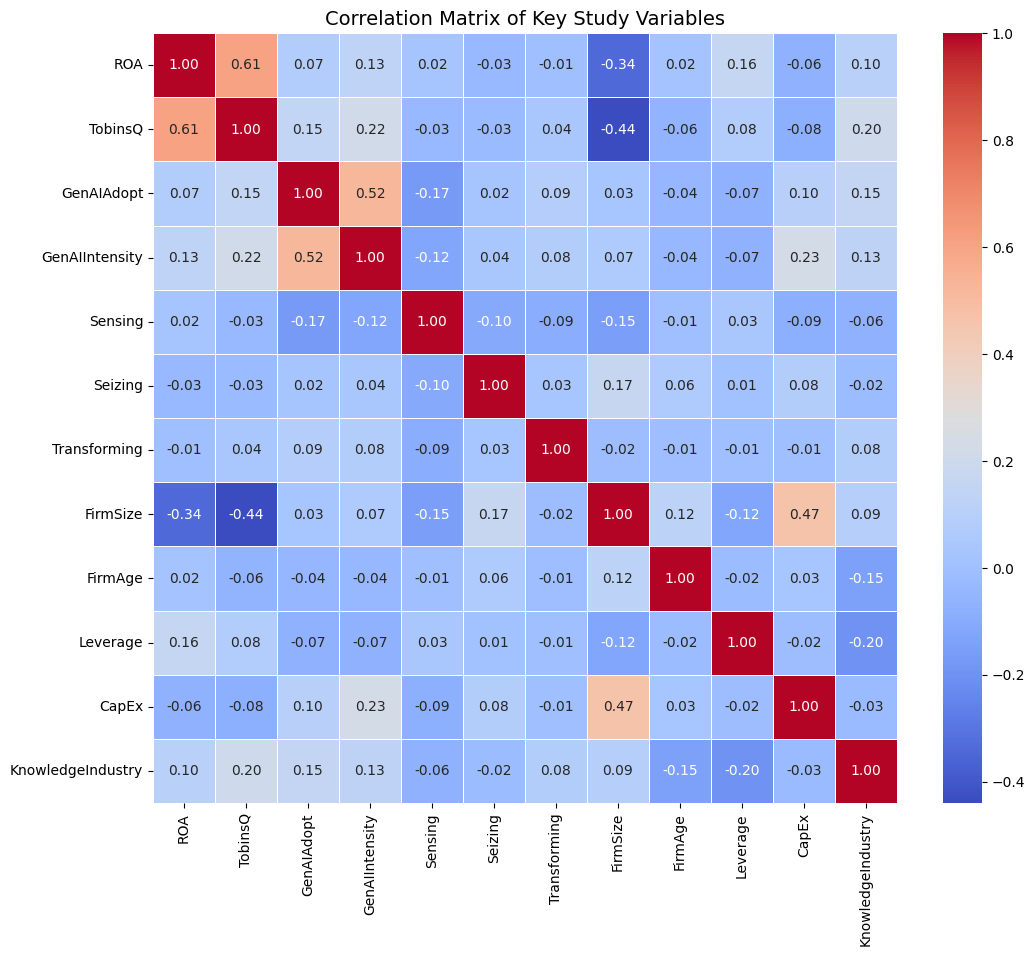

In [663]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Matrix of Key Study Variables", fontsize=14)
plt.show()


### Multi-collinearity Check

In [664]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_vars = [
    "GenAIAdopt",
    "GenAIIntensity",
    "Sensing",
    "Seizing",
    "Transforming",
    "FirmSize",
    "FirmAge",
    "Leverage",
    "CapEx",
    "KnowledgeIndustry"
]

X = df_model[vif_vars].dropna().copy()
X_const = sm.add_constant(X)

vif_df = pd.DataFrame()
vif_df["Variable"] = X_const.columns
vif_df["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

vif_df


,Variable,VIF
0,const,501.768
1,GenAIAdopt,1.413
2,GenAIIntensity,1.453
3,Sensing,1.066
4,Seizing,1.041
5,Transforming,1.021
6,FirmSize,1.392
7,FirmAge,1.046
8,Leverage,1.058
9,CapEx,1.367


### Histograms

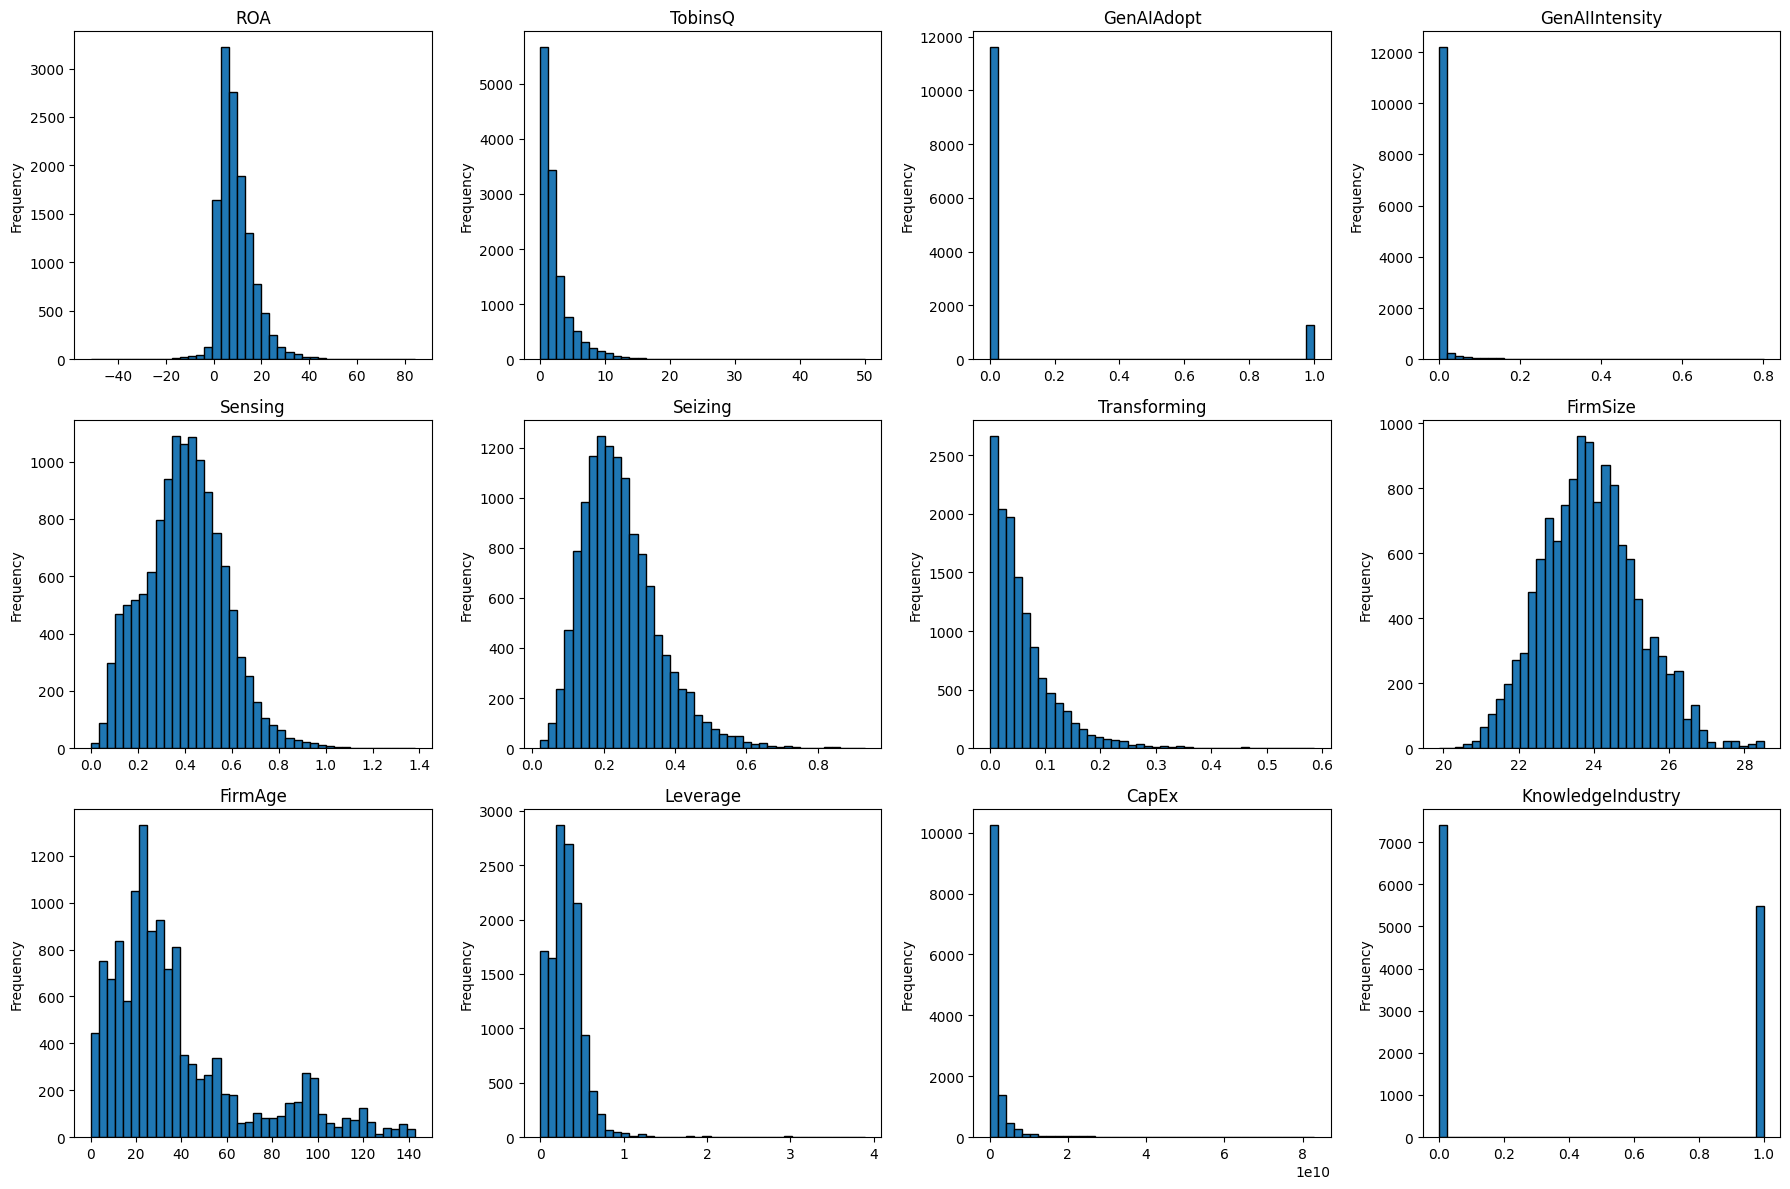

In [665]:
import matplotlib.pyplot as plt

dist_vars = [
    "ROA",
    "TobinsQ",
    "GenAIAdopt",
    "GenAIIntensity",
    "Sensing",
    "Seizing",
    "Transforming",
    "FirmSize",
    "FirmAge",
    "Leverage",
    "CapEx",
    "KnowledgeIndustry"
]

# Determine grid size
n_vars = len(dist_vars)
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

plt.figure(figsize=(18, 4 * n_rows))

for i, col in enumerate(dist_vars, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df_model[col], bins=40, edgecolor='black')
    plt.title(col, fontsize=12)
    plt.xlabel("")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()



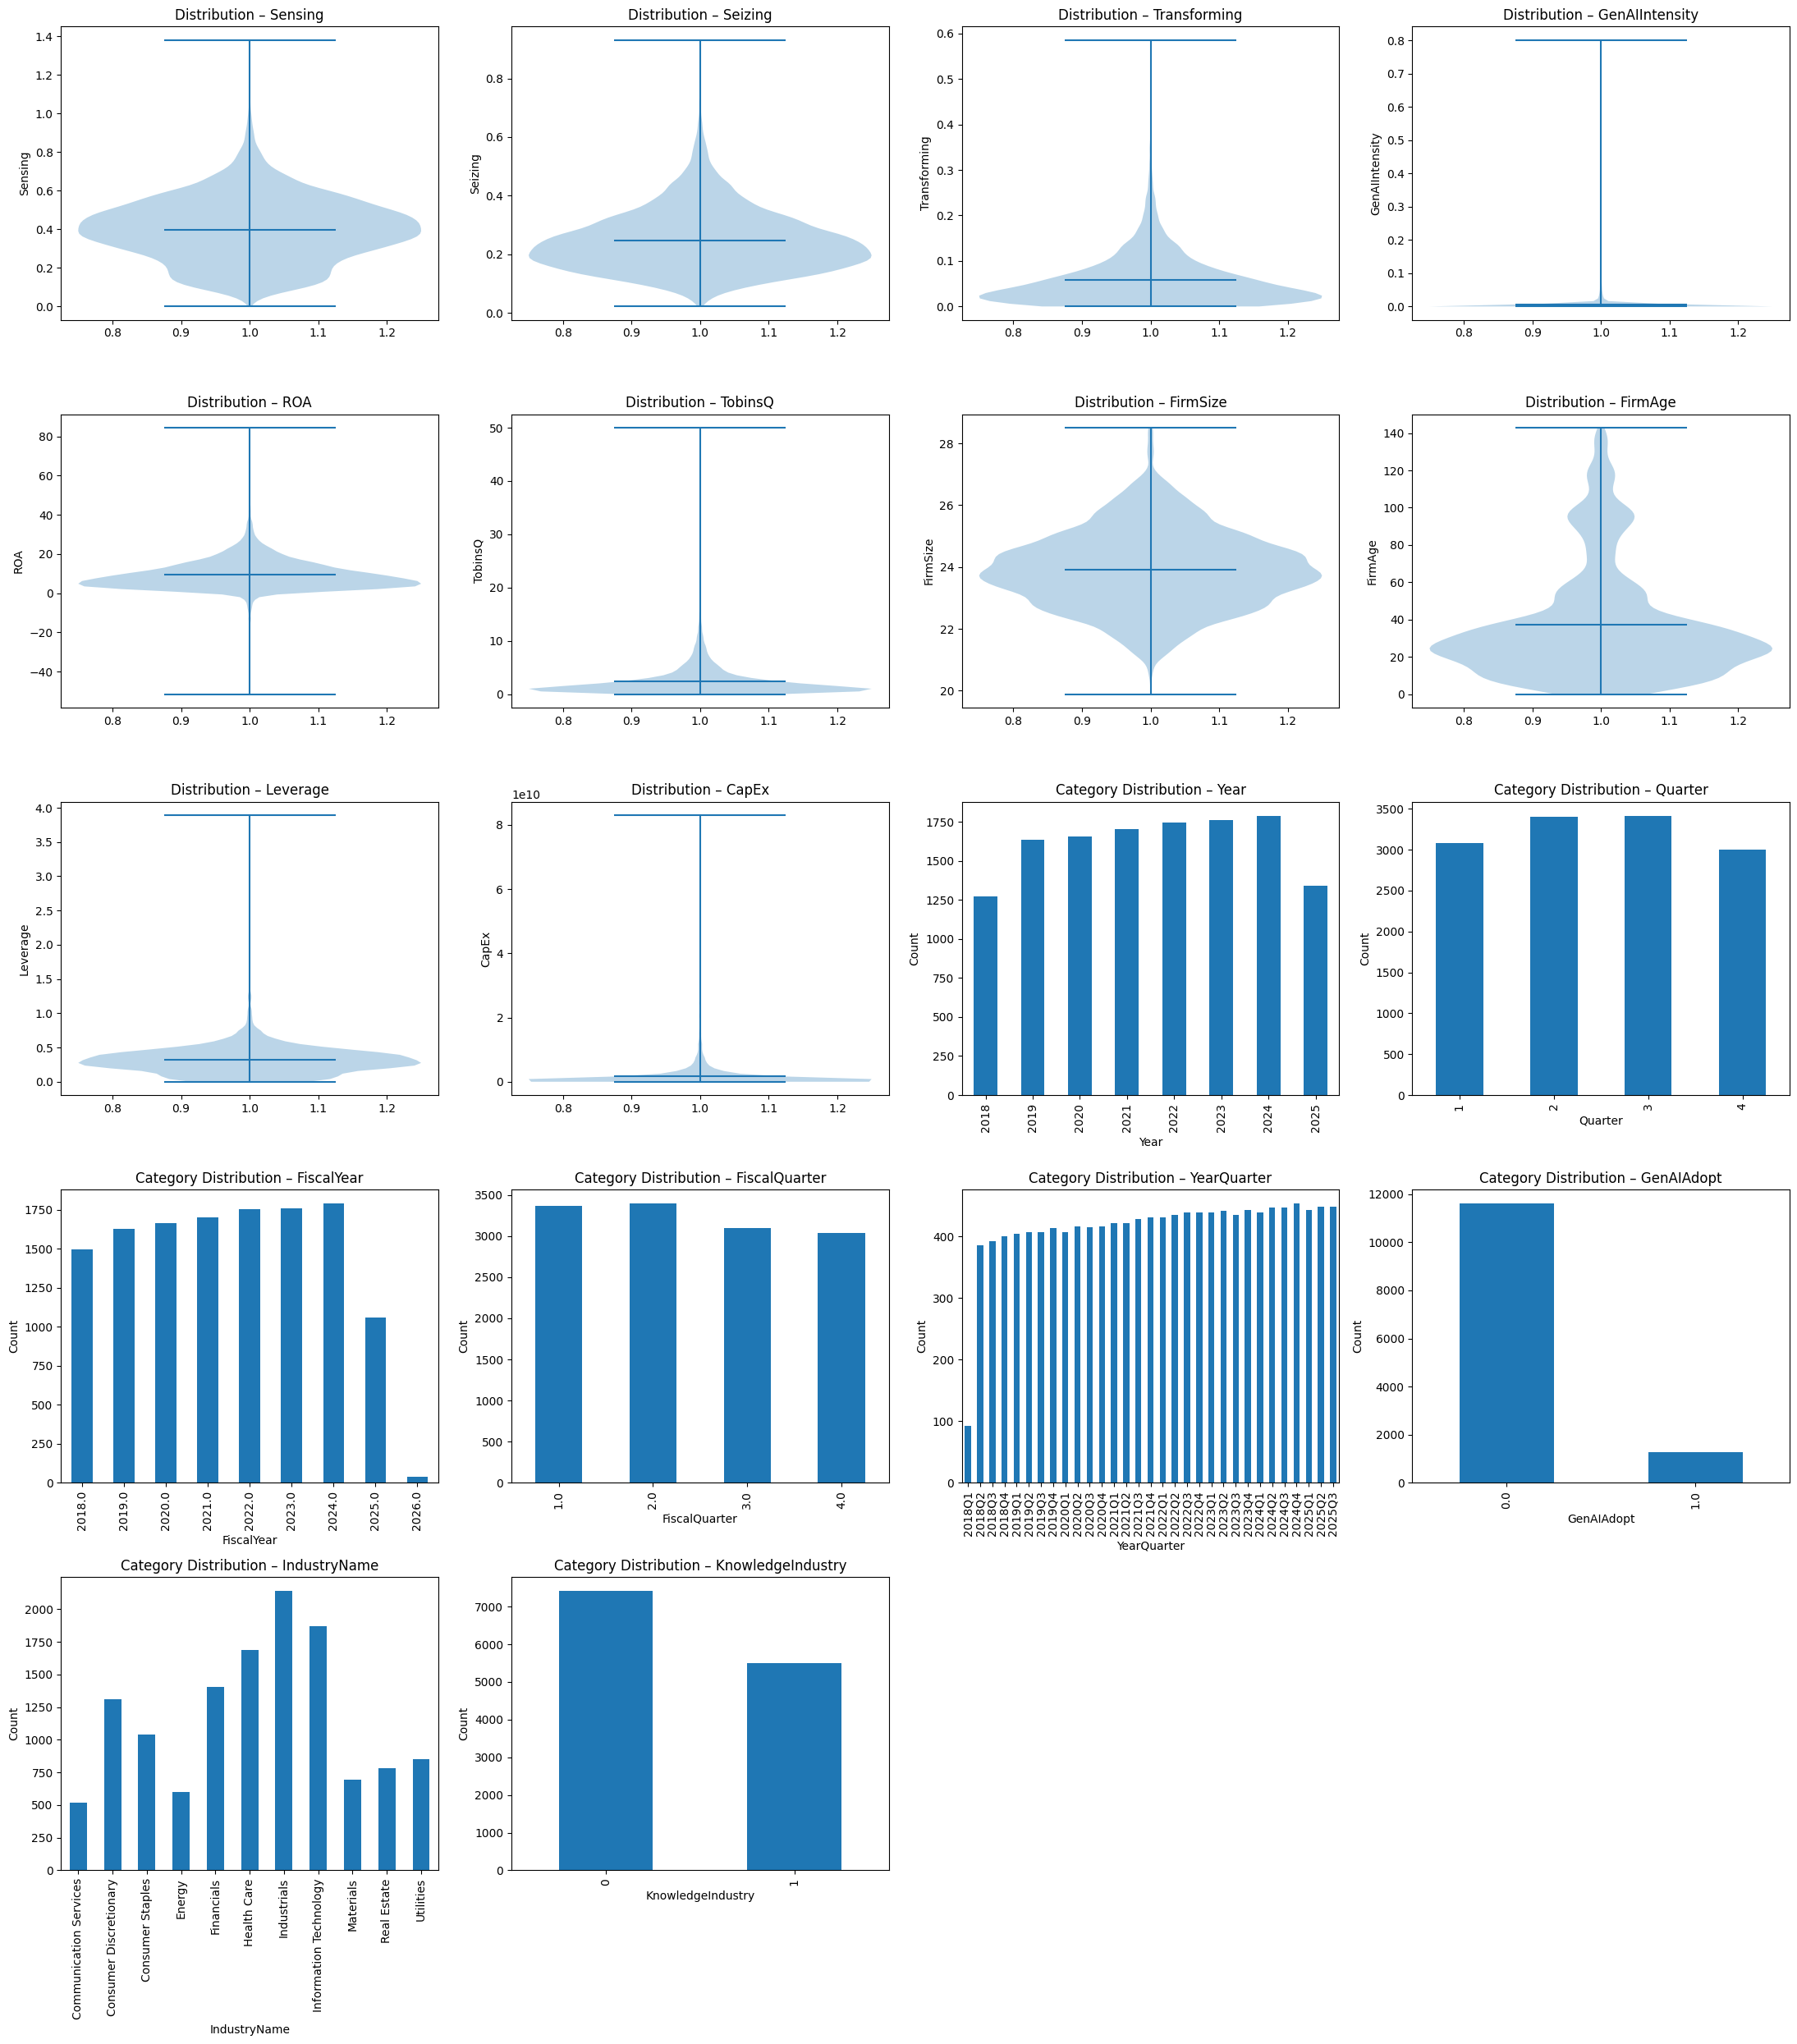

In [666]:
import matplotlib.pyplot as plt

# === COLUMN CLASSIFICATION (Updated with your new names) ===

numeric_cols = [
    "Sensing", 
    "Seizing", 
    "Transforming",
    "GenAIIntensity",
    "ROA",
    "TobinsQ",
    "FirmSize",
    "FirmAge",
    "Leverage",
    "CapEx"
]

categorical_cols = [
    "Year",
    "Quarter",
    "FiscalYear",
    "FiscalQuarter",
    "YearQuarter",
    "GenAIAdopt",
    "IndustryName",
    "KnowledgeIndustry"
]

# === CREATE SUBPLOTS FOR ALL PLOTS IN ONE VIEW ===

total_plots = len(numeric_cols) + len(categorical_cols)
n_cols = 4  # Number of columns in the subplot grid
n_rows = (total_plots + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 5 * n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

plot_idx = 0

# === Violin Plots for Numeric Columns ===
for col in numeric_cols:
    if col in df_model.columns:
        axes[plot_idx].violinplot(
            df_model[col].dropna(),
            showmeans=True,
            showextrema=True
        )
        axes[plot_idx].set_title(f"Distribution – {col}", fontsize=12)
        axes[plot_idx].set_ylabel(col)
        plot_idx += 1

# === Bar Charts for Categorical Columns ===
for col in categorical_cols:
    if col in df_model.columns:
        df_model[col].value_counts().sort_index().plot(
            kind="bar",
            ax=axes[plot_idx]
        )
        axes[plot_idx].set_title(f"Category Distribution – {col}", fontsize=12)
        axes[plot_idx].set_ylabel("Count")
        axes[plot_idx].set_xlabel(col)
        plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [667]:
df_model[dist_vars].skew().sort_values()


FirmSize             0.262
Sensing              0.291
KnowledgeIndustry    0.301
Seizing              1.056
FirmAge              1.379
ROA                  1.472
Transforming         2.208
GenAIAdopt           2.674
TobinsQ              4.209
Leverage             4.899
CapEx                7.584
GenAIIntensity      10.419
dtype: float64

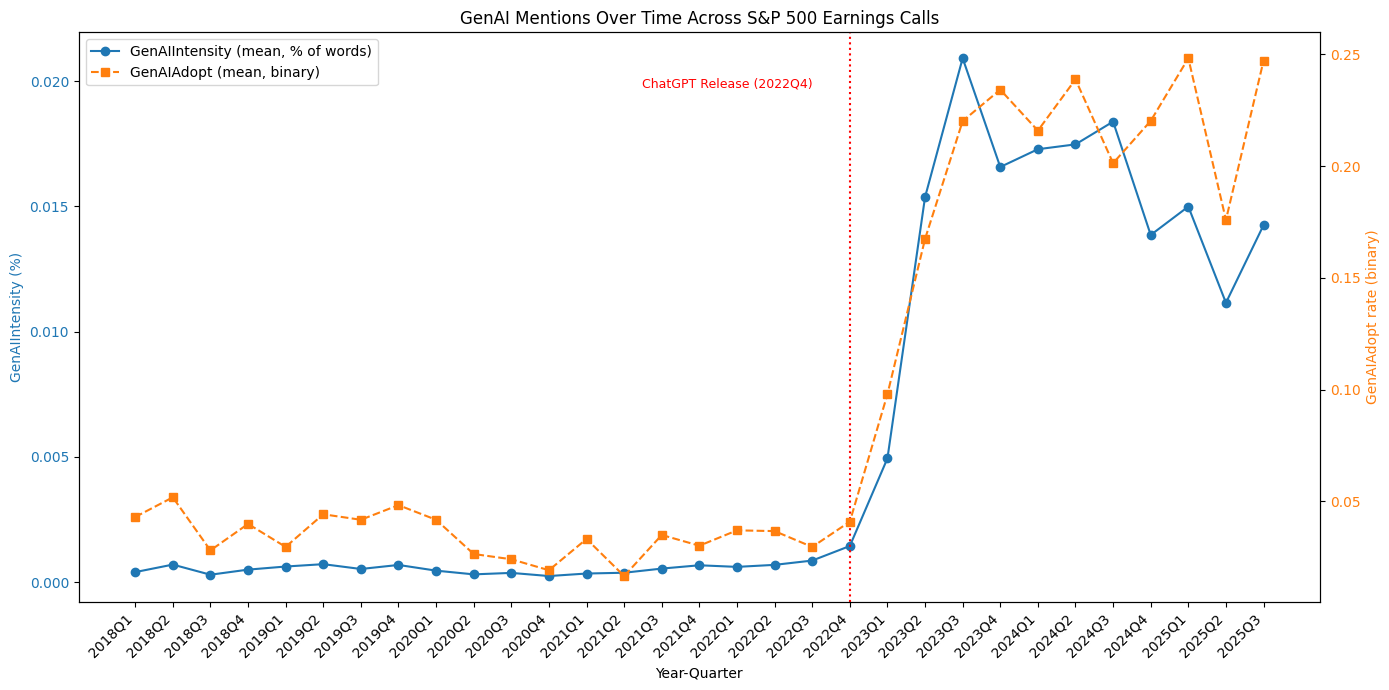

In [668]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv("Model.csv")

# --- Ensure variables exist ---
required_cols = ["Year", "Quarter", "GenAIIntensity", "GenAIAdopt"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' is missing from your dataset.")

# --- Create Year-Quarter label ---
df["YearQuarter"] = df["Year"].astype(str) + "Q" + df["Quarter"].astype(str)

# --- Sort for clean plotting ---
df = df.sort_values(["Year", "Quarter"])

# --- Aggregate by Y-Q ---
genai_trend = (
    df.groupby(["Year", "Quarter", "YearQuarter"], as_index=False)
      .agg(
          GenAIIntensity_mean=("GenAIIntensity", "mean"),   # now in %
          GenAIAdopt_rate=("GenAIAdopt", "mean"),           # fraction of firms
          Count=("GenAIAdopt", "count")
      )
)

# --- Create numeric time index for x-axis ---
genai_trend["t"] = range(len(genai_trend))

# --- PLOT with two y-axes ---
fig, ax1 = plt.subplots(figsize=(14, 7))

# Left axis: GenAI intensity (percentage of words)
color1 = "tab:blue"
ln1 = ax1.plot(
    genai_trend["t"],
    genai_trend["GenAIIntensity_mean"],
    marker="o",
    color=color1,
    label="GenAIIntensity (mean, % of words)"
)
ax1.set_xlabel("Year-Quarter")
ax1.set_ylabel("GenAIIntensity (%)", color=color1)
ax1.tick_params(axis='y', labelcolor=color1)

# X ticks
ax1.set_xticks(genai_trend["t"])
ax1.set_xticklabels(genai_trend["YearQuarter"], rotation=45, ha='right')

# Right axis: adoption rate (share of firms)
ax2 = ax1.twinx()
color2 = "tab:orange"
ln2 = ax2.plot(
    genai_trend["t"],
    genai_trend["GenAIAdopt_rate"],
    marker="s",
    linestyle="--",
    color=color2,
    label="GenAIAdopt (mean, binary)"
)
ax2.set_ylabel("GenAIAdopt rate (binary)", color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Vertical line at ChatGPT release (2022Q4)
if "2022Q4" in genai_trend["YearQuarter"].values:
    t_chatgpt = genai_trend.loc[genai_trend["YearQuarter"] == "2022Q4", "t"].iloc[0]
    ax1.axvline(t_chatgpt, color="red", linestyle=":", linewidth=1.5)

    # Place label to the LEFT of the line
    ax1.text(
        t_chatgpt - 1,                             # <–– shift left
        ax1.get_ylim()[1] * 0.9,                     # vertical placement
        "ChatGPT Release (2022Q4)",
        color="red",
        fontsize=9,
        ha="right"                                   # align text to the right
    )

# Combined legend from both axes
lines = ln1 + ln2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper left")

plt.title("GenAI Mentions Over Time Across S&P 500 Earnings Calls")
plt.tight_layout()
plt.show()



### pre-process the data

In [669]:

# ---------------------------------------
# 2. Winsorize ROA and TobinsQ
# ---------------------------------------
df_model["ROA"] = df_model["ROA"].clip(
    lower=df_model["ROA"].quantile(0.01),
    upper=df_model["ROA"].quantile(0.99)
)

df_model["TobinsQ"] = df_model["TobinsQ"].clip(
    lower=df_model["TobinsQ"].quantile(0.01),
    upper=df_model["TobinsQ"].quantile(0.99)
)

# ---------------------------------------
# 3. Log-transform CapEx (reduce skew)
# ---------------------------------------
df_model["CapEx"] = np.log1p(df_model["CapEx"])


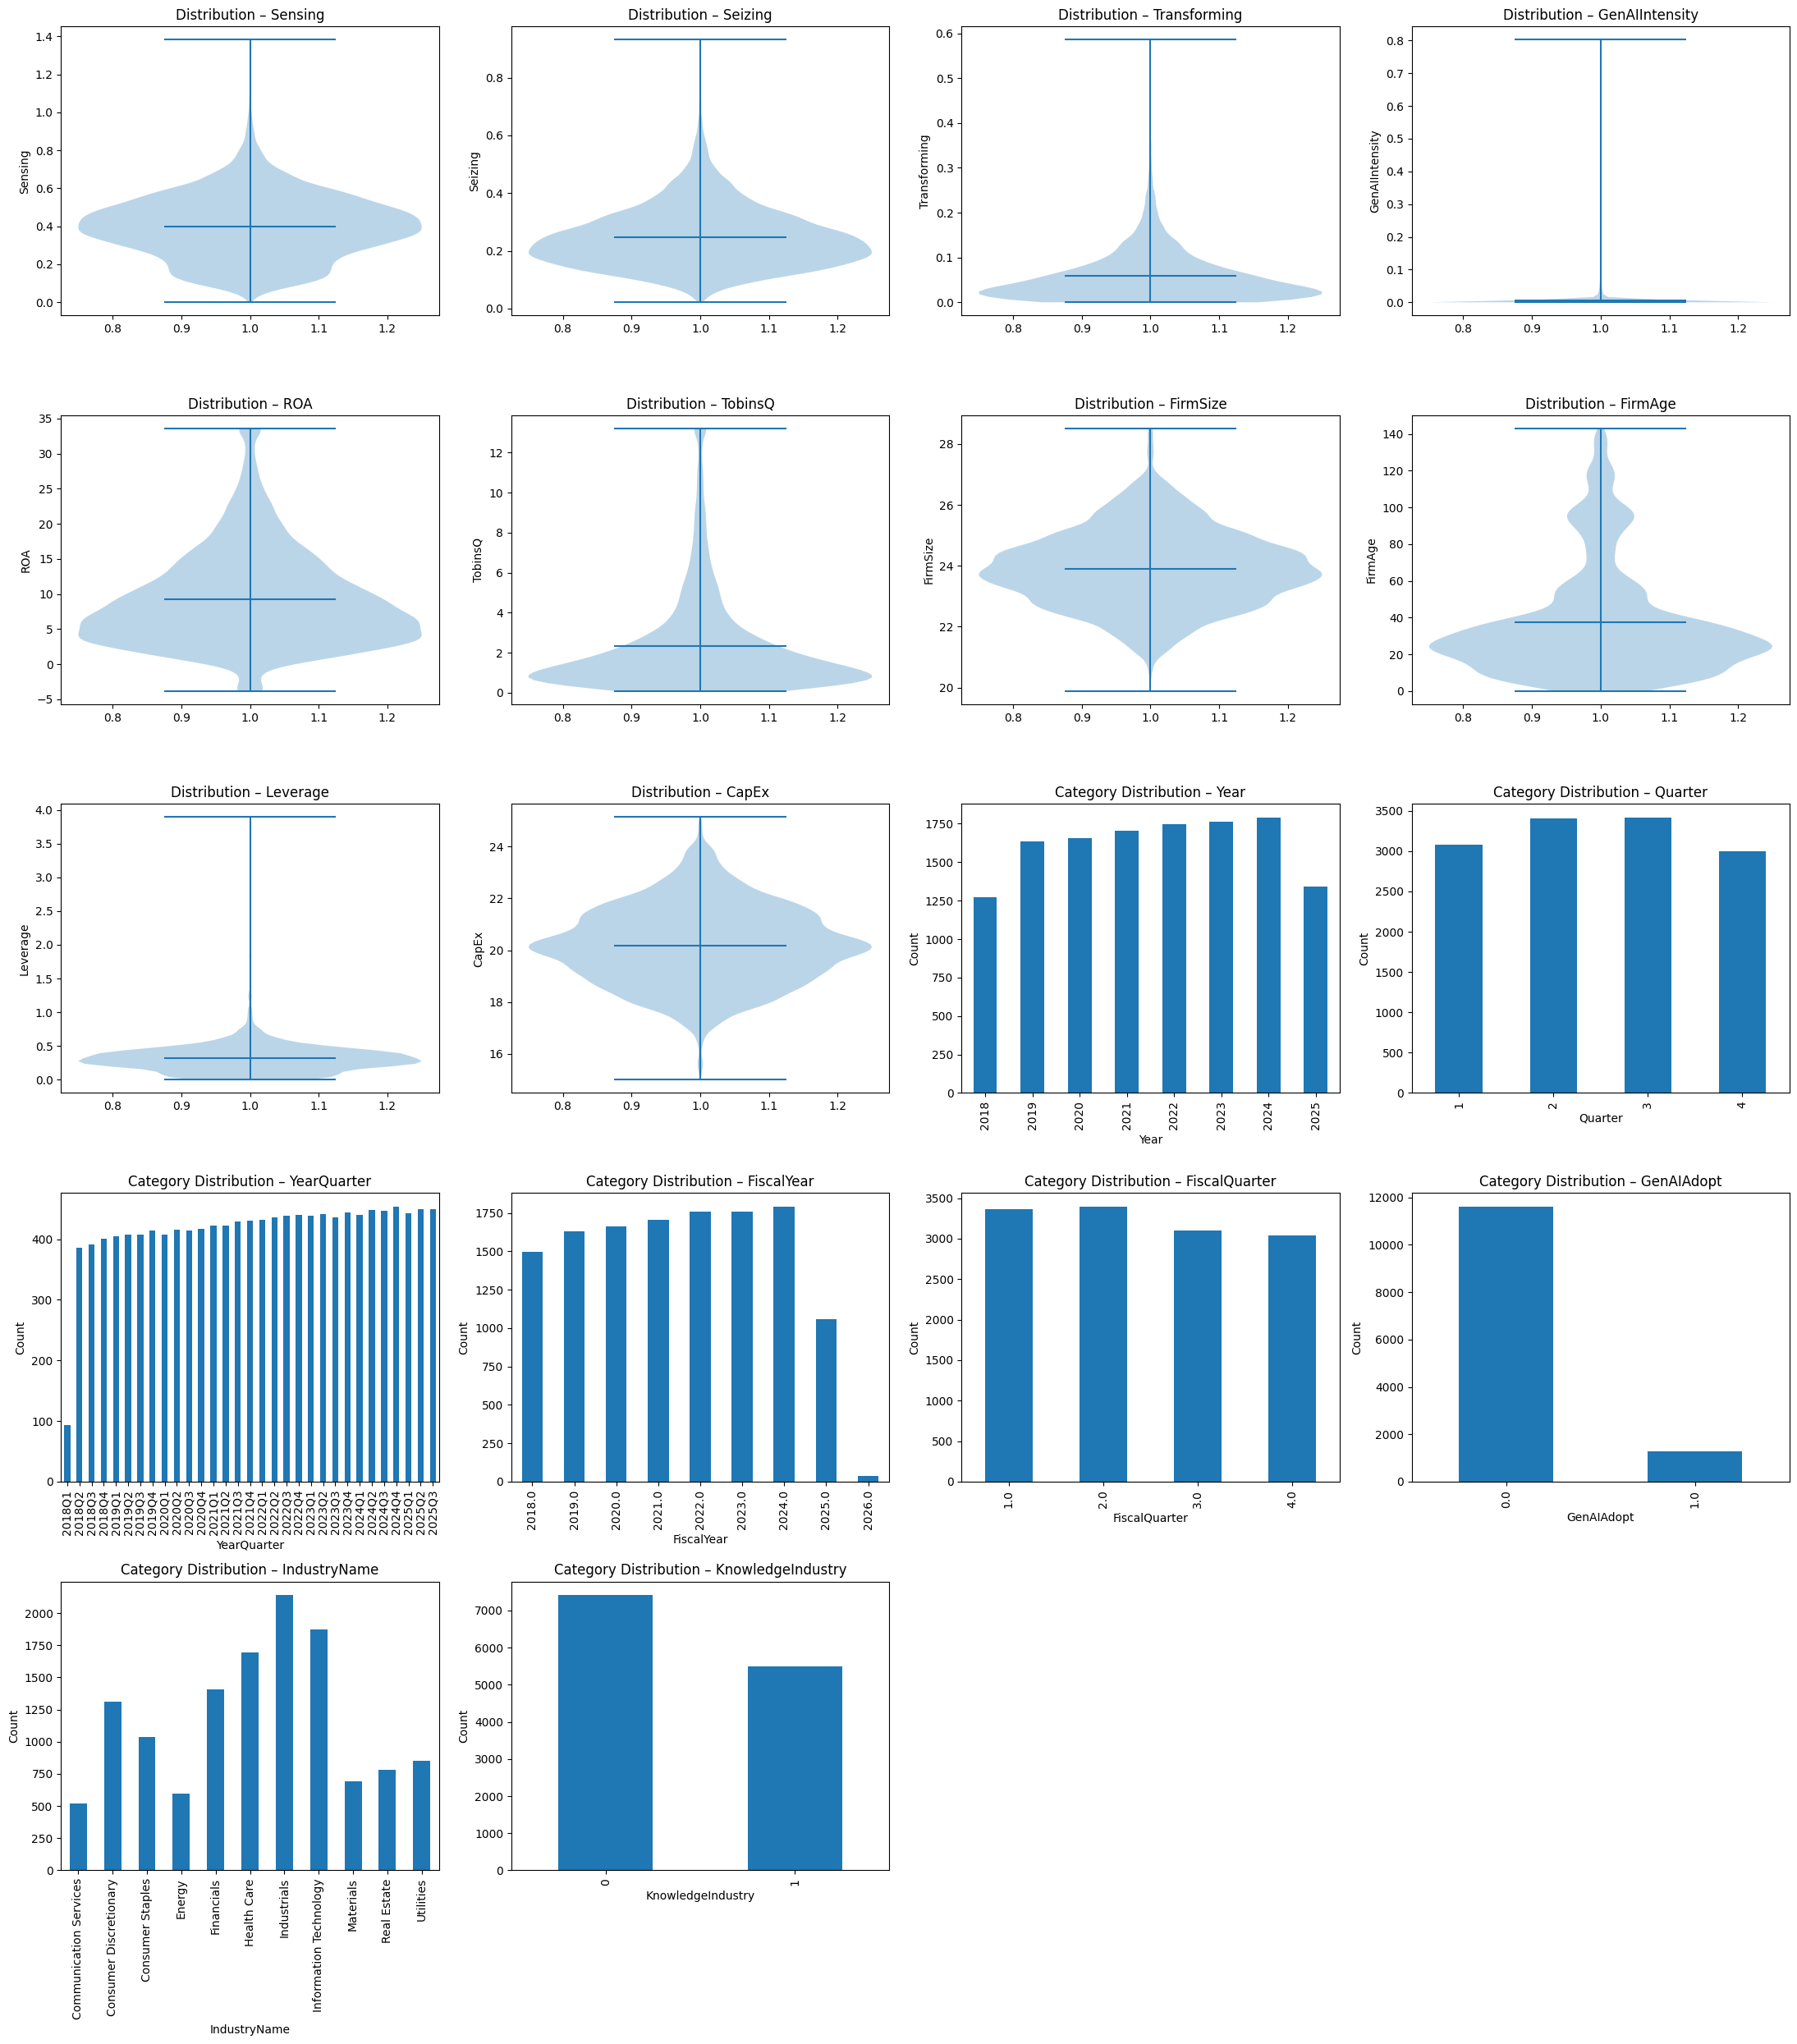

In [670]:
import matplotlib.pyplot as plt

# === COLUMN CLASSIFICATION (Updated with your new names) ===

numeric_cols = [
    "Sensing", 
    "Seizing", 
    "Transforming",
    "GenAIIntensity",
    "ROA",
    "TobinsQ",
    "FirmSize",
    "FirmAge",
    "Leverage",
    "CapEx"
]

categorical_cols = [
    "Year",
    "Quarter",
    "YearQuarter",
    "FiscalYear",
    "FiscalQuarter",
    "GenAIAdopt",
    "IndustryName",
    "KnowledgeIndustry"
]

# === CREATE SUBPLOTS FOR ALL PLOTS IN ONE VIEW ===

total_plots = len(numeric_cols) + len(categorical_cols)
n_cols = 4  # Number of columns in the subplot grid
n_rows = (total_plots + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(22, 5 * n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

plot_idx = 0

# === Violin Plots for Numeric Columns ===
for col in numeric_cols:
    if col in df_model.columns:
        axes[plot_idx].violinplot(
            df_model[col].dropna(),
            showmeans=True,
            showextrema=True
        )
        axes[plot_idx].set_title(f"Distribution – {col}", fontsize=12)
        axes[plot_idx].set_ylabel(col)
        plot_idx += 1

# === Bar Charts for Categorical Columns ===
for col in categorical_cols:
    if col in df_model.columns:
        df_model[col].value_counts().sort_index().plot(
            kind="bar",
            ax=axes[plot_idx]
        )
        axes[plot_idx].set_title(f"Category Distribution – {col}", fontsize=12)
        axes[plot_idx].set_ylabel("Count")
        axes[plot_idx].set_xlabel(col)
        plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

## Descriptive Statistics Text-Based variables

### External Validation: Comparing Groups (Post-GPT and Industry)

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as smf

# your dataframe
df = df_model.copy()

# variables of interest
text_vars = ["GenAIAdopt", "GenAIIntensity", "Sensing", "Seizing", "Transforming"]

# define periods
pre_mask = df["Year"] < 2023          # 2018–2022
post_mask = df["Year"] >= 2023        # 2023–2025

pre = df.loc[pre_mask, :]
post = df.loc[post_mask, :]

print(pre["Year"].min(), pre["Year"].max(), pre.shape[0])
print(post["Year"].min(), post["Year"].max(), post.shape[0])


2018 2022 8011
2023 2025 4891


In [ ]:
results_mean = []

for var in text_vars:
    pre_vals = pre[var].dropna()
    post_vals = post[var].dropna()
    
    # independent samples t-test (Welch, unequal var)
    tstat, pval = stats.ttest_ind(pre_vals, post_vals, equal_var=False)
    
    results_mean.append({
        "Variable": var,
        "PreGPT_mean": pre_vals.mean(),
        "PreGPT_std": pre_vals.std(),
        "PostGPT_mean": post_vals.mean(),
        "PostGPT_std": post_vals.std(),
        "t_stat": tstat,
        "p_value": pval
    })

mean_comp_df = pd.DataFrame(results_mean)
mean_comp_df.round(4)


,Variable,PreGPT_mean,PreGPT_std,PostGPT_mean,PostGPT_std,t_stat,p_value
0,GenAIAdopt,0.035,0.182,0.206,0.405,-28.011,0.000
1,GenAIIntensity,0.001,0.004,0.015,0.055,-18.282,0.000
2,Sensing,0.450,0.144,0.316,0.173,45.436,0.000
3,Seizing,0.237,0.103,0.261,0.113,-12.070,0.000
4,Transforming,0.059,0.058,0.058,0.059,0.243,0.808


In [ ]:
# correlation matrices in each period
corr_pre = pre[text_vars].corr()
corr_post = post[text_vars].corr()

print("Correlation matrix – Pre-GPT (2018–2022)")
corr_pre.round(3)




Correlation matrix – Pre-GPT (2018–2022)


,GenAIAdopt,GenAIIntensity,Sensing,Seizing,Transforming
GenAIAdopt,1.000,0.682,-0.044,0.016,0.069
GenAIIntensity,0.682,1.000,-0.041,0.002,0.042
Sensing,-0.044,-0.041,1.000,-0.104,-0.135
Seizing,0.016,0.002,-0.104,1.000,0.024
Transforming,0.069,0.042,-0.135,0.024,1.000


In [ ]:
print("\nCorrelation matrix – Post-GPT (2023–2025)")
corr_post.round(3)


Correlation matrix – Post-GPT (2023–2025)


,GenAIAdopt,GenAIIntensity,Sensing,Seizing,Transforming
GenAIAdopt,1.000,0.534,-0.087,-0.022,0.118
GenAIIntensity,0.534,1.000,-0.070,0.025,0.125
Sensing,-0.087,-0.070,1.000,-0.024,-0.052
Seizing,-0.022,0.025,-0.024,1.000,0.043
Transforming,0.118,0.125,-0.052,0.043,1.000


In [ ]:
# optional: compare the two matrices element-wise
corr_diff = corr_post - corr_pre
print("\nDifference in correlations (Post – Pre)")
corr_diff.round(3)


Difference in correlations (Post – Pre)


,GenAIAdopt,GenAIIntensity,Sensing,Seizing,Transforming
GenAIAdopt,0.000,-0.148,-0.043,-0.038,0.049
GenAIIntensity,-0.148,0.000,-0.029,0.023,0.084
Sensing,-0.043,-0.029,0.000,0.080,0.084
Seizing,-0.038,0.023,0.080,0.000,0.019
Transforming,0.049,0.084,0.084,0.019,0.000


In [ ]:
group_0 = df[df["KnowledgeIndustry"] == 0]   # Non-knowledge industries
group_1 = df[df["KnowledgeIndustry"] == 1]   # Knowledge-intensive industries

text_vars = ["GenAIAdopt", "GenAIIntensity", "Sensing", "Seizing", "Transforming"]

print(group_0.shape, group_1.shape)


(7411, 21) (5491, 21)


In [ ]:
from scipy import stats
import pandas as pd

results_mean = []

for var in text_vars:
    vals0 = group_0[var].dropna()
    vals1 = group_1[var].dropna()

    tstat, pval = stats.ttest_ind(vals0, vals1, equal_var=False)

    results_mean.append({
        "Variable": var,
        "Group0_mean": vals0.mean(),
        "Group1_mean": vals1.mean(),
        "t_stat": tstat,
        "p_value": pval
    })

mean_comp_df = pd.DataFrame(results_mean)
mean_comp_df.round(4)


,Variable,Group0_mean,Group1_mean,t_stat,p_value
0,GenAIAdopt,0.061,0.152,-16.358,0.000
1,GenAIIntensity,0.002,0.011,-12.895,0.000
2,Sensing,0.409,0.387,7.256,0.000
3,Seizing,0.248,0.244,2.291,0.022
4,Transforming,0.055,0.064,-8.789,0.000


In [ ]:
import pandas as pd

df = df_model.copy()

# Ensure GenAIAdopt is binary (0/1)
df["GenAIAdopt_bin"] = (df["GenAIAdopt"] > 0).astype(int)

# 1) Total number of distinct firms
total_firms = df["RIC"].nunique()

# 2) Firms that mentioned GenAI at least once
firms_with_genai = df[df["GenAIAdopt_bin"] == 1]["RIC"].unique()
num_firms_with_genai = len(firms_with_genai)

# 4) Percentage
percentage = (num_firms_with_genai / total_firms) * 100

print("Total distinct firms:", total_firms)
print("Firms that talked about GenAI:", num_firms_with_genai)
print(f"Percentage of firms mentioning GenAI: {percentage:.2f}%")

print("\nList of firms that talked about GenAI:")
print(firms_with_genai)


Total distinct firms: 472
Firms that talked about GenAI: 299
Firms that never talked about GenAI: 472
Percentage of firms mentioning GenAI: 63.35%

List of firms that talked about GenAI:
['AAPL.OQ' 'ABNB.OQ' 'ACN.N' 'ADBE.OQ' 'ADI.OQ' 'ADM.N' 'ADP.OQ' 'ADSK.OQ'
 'AEP.OQ' 'AES.N' 'AKAM.OQ' 'ALGN.OQ' 'AMAT.OQ' 'AMD.OQ' 'AMGN.OQ' 'AMP.N'
 'AMT.N' 'AMZN.OQ' 'ANET.N' 'AON.N' 'APA.OQ' 'APH.N' 'APP.OQ' 'APTV.N'
 'ARE.N' 'AVB.N' 'AVGO.OQ' 'AVY.N' 'AXON.OQ' 'BBY.N' 'BDX.N' 'BEN.N'
 'BG.N' 'BK.N' 'BKNG.OQ' 'BKR.OQ' 'BLDR.N' 'BR.N' 'BSX.N' 'BX.N' 'BXP.N'
 'C.N' 'CARR.N' 'CAT.N' 'CBOE.Z' 'CBRE.N' 'CCI.N' 'CCL.N' 'CDNS.OQ'
 'CDW.OQ' 'CFG.N' 'CHRW.OQ' 'CHTR.OQ' 'CI.N' 'CL.N' 'CLX.N' 'CMCSA.OQ'
 'CMG.N' 'CNC.N' 'CNP.N' 'COF.N' 'COIN.OQ' 'COP.N' 'COR.N' 'CPB.OQ'
 'CPRT.OQ' 'CPT.N' 'CRM.N' 'CRWD.OQ' 'CSCO.OQ' 'CSGP.OQ' 'CTAS.OQ'
 'CTSH.OQ' 'CVS.N' 'D.N' 'DAL.N' 'DASH.OQ' 'DAY.N' 'DD.N' 'DDOG.OQ' 'DE.N'
 'DECK.N' 'DELL.N' 'DGX.N' 'DLR.N' 'DOC.N' 'DOW.N' 'DPZ.OQ' 'DRI.N'
 'DTE.N' 'DUK.N' 'DVN.N' 'DXCM.OQ

In [ ]:
genai_counts = (
    df.groupby("RIC")["GenAIAdopt_bin"]
      .sum()
      .reset_index()
      .rename(columns={"GenAIAdopt_bin": "GenAIMentionCount"})
)

print(genai_counts.sort_values("GenAIMentionCount", ascending=False))


         RIC  GenAIMentionCount
301  MSFT.OQ                 27
322  NVDA.OQ                 23
316    NOW.N                 21
111  CTSH.OQ                 19
81   CHRW.OQ                 16
..       ...                ...
262   LIN.OQ                  0
269  LULU.OQ                  0
271    LVS.N                  0
272     LW.N                  0
471    ZTS.N                  0

[472 rows x 2 columns]


In [ ]:
df = df_model.copy()

# Average per firm across all periods
dc_means = df.groupby("RIC")[["Sensing", "Seizing", "Transforming"]].mean()

# Sort each capability
best_sensers = dc_means["Sensing"].sort_values(ascending=False)
best_seizers = dc_means["Seizing"].sort_values(ascending=False)
best_transformers = dc_means["Transforming"].sort_values(ascending=False)

print("Top Sensers:\n", best_sensers.head(10))
print("\nTop Seizers:\n", best_seizers.head(10))
print("\nTop Transformers:\n", best_transformers.head(10))


Top Sensers:
 RIC
PCAR.OQ    0.788
LRCX.OQ    0.785
MAA.N      0.766
GRMN.N     0.703
EXR.N      0.687
GOOGL.OQ   0.659
ANET.N     0.654
VTR.N      0.653
DVA.N      0.642
FDS.N      0.616
Name: Sensing, dtype: float64

Top Seizers:
 RIC
KVUE.N    0.665
TROW.OQ   0.608
FRT.N     0.549
SNDK.OQ   0.503
CL.N      0.492
CLX.N     0.473
NKE.N     0.473
EL.N      0.461
BLK.N     0.461
KKR.N     0.453
Name: Seizing, dtype: float64

Top Transformers:
 RIC
VRSN.OQ   0.252
CRM.N     0.250
MMM.N     0.218
NOW.N     0.217
PNR.N     0.206
ADSK.OQ   0.198
WAB.N     0.184
FDX.N     0.178
WTW.OQ    0.165
SWK.N     0.157
Name: Transforming, dtype: float64


In [ ]:
# Sum of scores across the whole dataset for each capability
total_sensing = df["Sensing"].sum()
total_seizing = df["Seizing"].sum()
total_transforming = df["Transforming"].sum()

# Sum per firm
dc_sums = df.groupby("RIC")[["Sensing", "Seizing", "Transforming"]].sum()

# Convert to percentage share of total
dc_percent = pd.DataFrame({
    "Sensing_pct": dc_sums["Sensing"] / total_sensing * 100,
    "Seizing_pct": dc_sums["Seizing"] / total_seizing * 100,
    "Transforming_pct": dc_sums["Transforming"] / total_transforming * 100
})

print(dc_percent.sort_values("Sensing_pct", ascending=False).head(10))
print(dc_percent.sort_values("Seizing_pct", ascending=False).head(10))
print(dc_percent.sort_values("Transforming_pct", ascending=False).head(10))


          Sensing_pct  Seizing_pct  Transforming_pct
RIC                                                 
LRCX.OQ         0.472        0.217             0.227
PCAR.OQ         0.459        0.153             0.090
GRMN.N          0.409        0.148             0.163
EXR.N           0.387        0.166             0.086
GOOGL.OQ        0.384        0.386             0.246
VTR.N           0.380        0.337             0.166
DVA.N           0.374        0.209             0.063
FDS.N           0.371        0.281             0.336
TDG.N           0.358        0.151             0.162
UHS.N           0.355        0.097             0.051
        Sensing_pct  Seizing_pct  Transforming_pct
RIC                                               
CL.N          0.178        0.464             0.160
CLX.N         0.253        0.461             0.238
EL.N          0.174        0.449             0.270
NKE.N         0.121        0.446             0.345
MS.N          0.223        0.413             0.369
DTE.N  

In [ ]:
summary_table = pd.DataFrame({
    "Avg_Sensing": best_sensers,
    "Avg_Seizing": best_seizers,
    "Avg_Transforming": best_transformers,
    "Pct_Sensing": dc_percent["Sensing_pct"],
    "Pct_Seizing": dc_percent["Seizing_pct"],
    "Pct_Transforming": dc_percent["Transforming_pct"]
})

summary_table.head()


,Avg_Sensing,Avg_Seizing,Avg_Transforming,Pct_Sensing,Pct_Seizing,Pct_Transforming
RIC,,,,,,
A.N,0.448,0.201,0.059,0.269,0.196,0.241
AAPL.OQ,0.440,0.193,0.064,0.265,0.188,0.264
ABBV.N,0.407,0.264,0.032,0.229,0.241,0.123
ABNB.OQ,0.449,0.231,0.029,0.105,0.087,0.045
ABT.N,0.404,0.277,0.046,0.235,0.261,0.184


In [ ]:
summary_table.sort_values("Pct_Sensing", ascending=False).head(10)


,Avg_Sensing,Avg_Seizing,Avg_Transforming,Pct_Sensing,Pct_Seizing,Pct_Transforming
RIC,,,,,,
LRCX.OQ,0.785,0.222,0.055,0.472,0.217,0.227
PCAR.OQ,0.788,0.162,0.023,0.459,0.153,0.090
GRMN.N,0.703,0.157,0.041,0.409,0.148,0.163
EXR.N,0.687,0.182,0.022,0.387,0.166,0.086
GOOGL.OQ,0.659,0.410,0.062,0.384,0.386,0.246
VTR.N,0.653,0.357,0.042,0.380,0.337,0.166
DVA.N,0.642,0.222,0.016,0.374,0.209,0.063
FDS.N,0.616,0.289,0.082,0.371,0.281,0.336
TDG.N,0.595,0.155,0.039,0.358,0.151,0.162


In [ ]:
summary_table.sort_values("Pct_Seizing", ascending=False).head(10)

,Avg_Sensing,Avg_Seizing,Avg_Transforming,Pct_Sensing,Pct_Seizing,Pct_Transforming
RIC,,,,,,
CL.N,0.305,0.492,0.040,0.178,0.464,0.160
CLX.N,0.421,0.473,0.058,0.253,0.461,0.238
EL.N,0.290,0.461,0.066,0.174,0.449,0.270
NKE.N,0.207,0.473,0.087,0.121,0.446,0.345
MS.N,0.383,0.438,0.093,0.223,0.413,0.369
DTE.N,0.508,0.437,0.082,0.296,0.412,0.325
PG.N,0.328,0.420,0.039,0.198,0.409,0.160
HSY.N,0.511,0.432,0.061,0.298,0.407,0.244
PEP.OQ,0.404,0.431,0.050,0.235,0.407,0.198


In [ ]:
summary_table.sort_values("Pct_Transforming", ascending=False).head(10)

,Avg_Sensing,Avg_Seizing,Avg_Transforming,Pct_Sensing,Pct_Seizing,Pct_Transforming
RIC,,,,,,
CRM.N,0.151,0.224,0.250,0.091,0.218,1.025
VRSN.OQ,0.459,0.162,0.252,0.267,0.153,1.002
MMM.N,0.398,0.283,0.218,0.231,0.267,0.867
NOW.N,0.267,0.251,0.217,0.155,0.237,0.861
PNR.N,0.597,0.248,0.206,0.347,0.234,0.820
ADSK.OQ,0.362,0.251,0.198,0.218,0.244,0.815
FDX.N,0.354,0.192,0.178,0.213,0.187,0.733
ACN.N,0.270,0.302,0.154,0.162,0.295,0.631
SWK.N,0.297,0.319,0.157,0.173,0.301,0.623


# Save the final dataset and move to RStudio for regressions

In [671]:
df_model.to_csv("thesis_regression_data.csv", index=False)

In [672]:
df_model2 = pd.read_csv("thesis_regression_data.csv")

In [673]:
df_model2.head()

,RIC,CompanyName,Date,Year,Quarter,YearQuarter,FiscalYear,FiscalQuarter,Sensing,Seizing,...,GenAIIntensity,GenAIAdopt,ROA,TobinsQ,FirmSize,FirmAge,Leverage,CapEx,IndustryName,KnowledgeIndustry
0,A.N,Agilent Technologies Inc,2018-02-14,2018,1,2018Q1,"2,018.000",1.000,0.447,0.224,...,0.000,0.000,9.329,2.560,22.855,19.000,0.239,18.986,Health Care,1
1,A.N,Agilent Technologies Inc,2018-05-14,2018,2,2018Q2,"2,018.000",2.000,0.701,0.157,...,0.000,0.000,10.683,2.348,22.855,19.000,0.239,18.986,Health Care,1
2,A.N,Agilent Technologies Inc,2018-08-14,2018,3,2018Q3,"2,018.000",3.000,0.485,0.204,...,0.000,0.000,10.857,2.669,22.855,19.000,0.239,18.986,Health Care,1
3,A.N,Agilent Technologies Inc,2018-11-19,2018,4,2018Q4,"2,018.000",4.000,0.532,0.188,...,0.000,0.000,11.414,2.516,22.868,19.000,0.211,18.992,Health Care,1
4,A.N,Agilent Technologies Inc,2019-02-20,2019,1,2019Q1,"2,019.000",1.000,0.597,0.230,...,0.000,0.000,13.017,2.988,22.868,20.000,0.211,18.992,Health Care,1


In [674]:
# Filter to post-ChatGPT period (2023Q1 onward)
df_model2 = df_model2[df_model2["Year"] > 2022]

# Optional: check how many observations remain
df_model2


,RIC,CompanyName,Date,Year,Quarter,YearQuarter,FiscalYear,FiscalQuarter,Sensing,Seizing,...,GenAIIntensity,GenAIAdopt,ROA,TobinsQ,FirmSize,FirmAge,Leverage,CapEx,IndustryName,KnowledgeIndustry
20,A.N,Agilent Technologies Inc,2023-02-28,2023,1,2023Q1,"2,023.000",1.000,0.396,0.294,...,0.000,0.000,15.767,3.884,23.078,24.000,0.263,19.489,Health Care,1
21,A.N,Agilent Technologies Inc,2023-05-23,2023,2,2023Q2,"2,023.000",2.000,0.444,0.151,...,0.000,0.000,15.425,3.372,23.078,24.000,0.263,19.489,Health Care,1
22,A.N,Agilent Technologies Inc,2023-08-15,2023,3,2023Q3,"2,023.000",3.000,0.513,0.248,...,0.000,0.000,14.700,3.106,23.078,24.000,0.263,19.489,Health Care,1
23,A.N,Agilent Technologies Inc,2023-11-20,2023,4,2023Q4,"2,023.000",4.000,0.408,0.167,...,0.000,0.000,13.940,3.785,23.099,24.000,0.254,19.513,Health Care,1
24,A.N,Agilent Technologies Inc,2024-02-27,2024,1,2024Q1,"2,024.000",1.000,0.604,0.192,...,0.000,0.000,13.740,3.962,23.099,25.000,0.254,19.513,Health Care,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12897,ZTS.N,Zoetis Inc,2024-08-06,2024,3,2024Q3,"2,024.000",2.000,0.222,0.339,...,0.000,0.000,17.533,6.196,23.383,12.000,0.460,20.411,Health Care,1
12898,ZTS.N,Zoetis Inc,2024-11-04,2024,4,2024Q4,"2,024.000",3.000,0.172,0.408,...,0.000,0.000,17.733,5.145,23.383,12.000,0.460,20.411,Health Care,1
12899,ZTS.N,Zoetis Inc,2025-02-13,2025,1,2025Q1,"2,024.000",4.000,0.107,0.247,...,0.000,0.000,18.650,5.159,23.379,13.000,0.462,20.300,Health Care,1
12900,ZTS.N,Zoetis Inc,2025-05-06,2025,2,2025Q2,"2,025.000",1.000,0.191,0.438,...,0.000,0.000,19.900,4.863,23.379,13.000,0.462,20.300,Health Care,1


In [675]:
df_model2.to_csv("thesis_regression_data2.csv.csv", index=False)